<a href="https://colab.research.google.com/github/ghiathnj/impacket/blob/master/25_08_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
from datetime import datetime
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble
from matplotlib import pyplot
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
#np.random.seed(42)
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sn 
from math import ceil
import calendar

###Resampling the time series data:

### finding the mean of each column's value for the interval of 15 minutes

In [ ]:
Energy_df = pd.read_csv('/content/drive/MyDrive/Masterarbeit/data_2019_run12.csv')
Energy_df["time"] = (pd.to_datetime(Energy_df['time']).add(pd.to_timedelta(Energy_df.time, unit='s')).dt.strftime('2019/%m/%d %H:%M:%S'))
Energy_df['time'] = pd.to_datetime(Energy_df['time'])
#Energy_df = Energy_df.set_index('time') 
###Energy_resampled = Energy_df.set_index('time').resample('15T').sum()
Energy_resampled = Energy_df.set_index('time').resample('15T').mean()
#Energy_resapled = Energy_df.resample('15T').sum()
dftest= Energy_resampled
dftest=dftest.reset_index()
dftest

time  Unnamed: 0          p_eh      p_target  \
0     2019-01-01 00:00:00         7.0  8.453945e+05 -2.000000e+06   
1     2019-01-01 00:15:00        22.0 -1.644030e+05 -1.789447e+06   
2     2019-01-01 00:30:00        37.0 -9.675248e+05 -1.578835e+06   
3     2019-01-01 00:45:00        52.0 -9.364160e+05 -1.126990e+06   
4     2019-01-01 01:00:00        67.0 -9.697502e+05 -1.018328e+06   
...                   ...         ...           ...           ...   
34939 2019-12-30 22:45:00    524092.0 -1.614645e+06 -1.462639e+06   
34940 2019-12-30 23:00:00    524107.0 -1.592423e+06 -2.000000e+06   
34941 2019-12-30 23:15:00    524122.0 -1.592423e+06 -9.591015e+05   
34942 2019-12-30 23:30:00    524137.0 -1.599086e+06 -1.253964e+06   
34943 2019-12-30 23:45:00    524152.0 -1.605746e+06 -1.485311e+06   

              d_abs  
0      2.845395e+06  
1      1.625044e+06  
2      6.113105e+05  
3      1.905739e+05  
4      5.069407e+04  
...             ...  
34939  1.520060e+05  
34940  4.075768e+05  
34941  6.333217e+05  
34942  3.451227e+05  
34943  1.204354e+05  

[34944 rows x 5 columns]

-Augmented dickey-fuller test :
-https://towardsdatascience.com/how-to-remove-non-stationarity-in-time-series-forecasting-563c05c4bfc7

The result of the dickey-fuller test consists of some values like test statistics, p-value critical values, etc. For dataset1 the test statistic value (-2.25) is not less than the critical values (-3.44 , -2.86 , -2.57) at different percentage . In this case, we cannot reject our null hypothesis and conclude that our data is not stationary,

-the ADF test one more times shows that the ADF statistic is much greater than the critical values at different levels, and also the p-value is much greater than 0.05 which signifies, we can fail to reject the null hypothesis at 90%, 95%, and 99% confidence, meaning the time series data is strongly non-stationary.

-When we run adfuller on the original distribution , the p-value was close to 1. After differencing, the p-value is flat 0, suggesting we reject the null and conclude the series is now stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(dftest['p_target'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -30.05043568906964
p-value: 0.0
Critical Values:
	1%: -3.4305374238711472
	5%: -2.8616228367115264
	10%: -2.566814091379453


In [ ]:
Energy_df

Unnamed: 0                time          p_eh      p_target  \
0                0 2019-01-01 00:00:00  7.725664e+05 -2.000000e+06   
1                1 2019-01-01 00:01:00  4.089311e+05 -2.000000e+06   
2                2 2019-01-01 00:02:00  4.089311e+05 -2.000000e+06   
3                3 2019-01-01 00:03:00  6.255978e+05 -2.000000e+06   
4                4 2019-01-01 00:04:00  9.892331e+05 -2.000000e+06   
...            ...                 ...           ...           ...   
524155      524155 2019-12-30 23:55:00 -1.536857e+06 -1.485311e+06   
524156      524156 2019-12-30 23:56:00 -1.570190e+06 -1.485311e+06   
524157      524157 2019-12-30 23:57:00 -1.636857e+06 -1.485311e+06   
524158      524158 2019-12-30 23:58:00 -1.603524e+06 -1.485311e+06   
524159      524159 2019-12-30 23:59:00 -1.636857e+06 -1.485311e+06   

               d_abs  
0       2.772566e+06  
1       2.408931e+06  
2       2.408931e+06  
3       2.625598e+06  
4       2.989233e+06  
...              ...  
524155  5.154631e+04  
524156  8.487964e+04  
524157  1.515463e+05  
524158  1.182130e+05  
524159  1.515463e+05  

[524160 rows x 5 columns]

# Time Series Preprocessing and Feature Engineering
A fundamental assumption of autoregressive models is that we can use past values to predict future ones. So, we need to create features to represent these past values. We call these lag variables, and they lag behind the actual time series by 1, 2, 3, or (many) more time steps.

Use the shift() method in pandas to create lagged variables.


https://h2o.ai/blog/an-introduction-to-time-series-modeling-time-series-preprocessing-and-feature-engineering/

In [ ]:
dftest['t-1'] = dftest['d_abs'].shift(1)
dftest['t-2'] = dftest['d_abs'].shift(2)
dftest['t-3'] = dftest['d_abs'].shift(3)
#lagged_feature_cols = ['t-3', 't-2', 't-1']
# Drop first 3 rows due to NaNs
#df_lagged = dftest.loc[3:,lagged_feature_cols +['d_abs']]
# Create feature df to use for aggregation calculations
#df_lagged_features = dftest.loc[:, lagged_feature_cols]
# Create aggregated features
#df_lagged['max'] = df_lagged_features.aggregate(np.max, axis=1)
#df_lagged['min'] = df_lagged_features.aggregate(np.min, axis=1)
#df_lagged
#dftest=dftest.merge(df_lagged[['max','min']],how='left',left_index=True,right_index=True)
#df_lagged
#df_lagged
dftest=dftest.loc[3:]
dftest

time  Unnamed: 0          p_eh      p_target  \
3     2019-01-01 00:45:00        52.0 -9.364160e+05 -1.126990e+06   
4     2019-01-01 01:00:00        67.0 -9.697502e+05 -1.018328e+06   
5     2019-01-01 01:15:00        82.0 -9.508551e+05 -1.043398e+06   
6     2019-01-01 01:30:00        97.0 -9.664093e+05 -8.768223e+05   
7     2019-01-01 01:45:00       112.0 -9.641928e+05 -6.665155e+05   
...                   ...         ...           ...           ...   
34939 2019-12-30 22:45:00    524092.0 -1.614645e+06 -1.462639e+06   
34940 2019-12-30 23:00:00    524107.0 -1.592423e+06 -2.000000e+06   
34941 2019-12-30 23:15:00    524122.0 -1.592423e+06 -9.591015e+05   
34942 2019-12-30 23:30:00    524137.0 -1.599086e+06 -1.253964e+06   
34943 2019-12-30 23:45:00    524152.0 -1.605746e+06 -1.485311e+06   

               d_abs            t-1           t-2           t-3  
3      190573.852231  611310.523395  1.625044e+06  2.845395e+06  
4       50694.072499  190573.852231  6.113105e+05  1.625044e+06  
5       92542.755958   50694.072499  1.905739e+05  6.113105e+05  
6       89586.979320   92542.755958  5.069407e+04  1.905739e+05  
7      297677.235726   89586.979320  9.254276e+04  5.069407e+04  
...              ...            ...           ...           ...  
34939  152005.965635  403993.287555  1.302634e+05  1.331115e+05  
34940  407576.799643  152005.965635  4.039933e+05  1.302634e+05  
34941  633321.745242  407576.799643  1.520060e+05  4.039933e+05  
34942  345122.702734  633321.745242  4.075768e+05  1.520060e+05  
34943  120435.359927  345122.702734  6.333217e+05  4.075768e+05  

[34941 rows x 8 columns]

In [ ]:
#extract important features
##https://www.geeksforgeeks.org/python-holidays-library/

def get_season(month):

    if month =='September' or month =='October' or month =='November':
      Season= 'Autumn'
    elif month =='December' or month == 'January' or month =='February':
      Season= 'Winter'
    elif month =='March' or month =='April' or month =='May':
      Season= 'Spring'
    else:
      Season = 'Summer'

    return Season
#------------------------------------------------------


dftest['Dates'] = pd.to_datetime(dftest['time']).dt.date
#dftest['TimeInHMS'] = pd.to_datetime(dftest['time']).dt.time
dftest['Hour']= pd.to_datetime(dftest['time']).dt.hour
dftest['minute']= pd.to_datetime(dftest['time']).dt.minute
#dftest['second']= pd.to_datetime(dftest['time']).dt.second
dftest['Day'] = pd.to_datetime(dftest['time']).dt.day_name()
dftest['DayOfYear'] = pd.to_datetime(dftest['time']).dt.dayofyear
dftest['Month'] = pd.to_datetime(dftest['time']).dt.month_name()
dftest['MonthInNum'] = pd.to_datetime(dftest['time']).dt.month
dftest['Quarter'] = pd.to_datetime(dftest['time']).dt.quarter
dftest['Year'] = pd.to_datetime(dftest['time']).dt.year
dftest['Weekday'] = pd.to_datetime(dftest['time']).dt.weekday
dftest['DaysOfMonth'] = pd.to_datetime(dftest['time']).dt.day
#dftest['WeekOfMonth'] = week_of_month(dftest['time'])
#The weekday() function of date class in datetime module, returns an integer between 0(monday) and 6(sunday)
dftest['Seasons'] = dftest['Month'].apply(lambda x: get_season(x))
dftest['Weekend'] = dftest['Weekday'].apply(lambda x: x>=5).astype('int')
dftest['WeekOfYear'] = pd.to_datetime(dftest['time']).dt.week
dftest['Holiday'] = pd.to_datetime(dftest['time']).dt.date.apply(lambda x: holidays.CountryHoliday('DE',prov='BW').get(x)).values.astype('bool').astype('int')
dftest['DayAheadWeekend'] = dftest['Weekday'].apply(lambda x: x==4).astype('int')
dftest['DayAfterWeekend'] = dftest['Weekday'].apply(lambda x: x==0).astype('int')
dftest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

time  Unnamed: 0          p_eh      p_target  \
3     2019-01-01 00:45:00        52.0 -9.364160e+05 -1.126990e+06   
4     2019-01-01 01:00:00        67.0 -9.697502e+05 -1.018328e+06   
5     2019-01-01 01:15:00        82.0 -9.508551e+05 -1.043398e+06   
6     2019-01-01 01:30:00        97.0 -9.664093e+05 -8.768223e+05   
7     2019-01-01 01:45:00       112.0 -9.641928e+05 -6.665155e+05   
...                   ...         ...           ...           ...   
34939 2019-12-30 22:45:00    524092.0 -1.614645e+06 -1.462639e+06   
34940 2019-12-30 23:00:00    524107.0 -1.592423e+06 -2.000000e+06   
34941 2019-12-30 23:15:00    524122.0 -1.592423e+06 -9.591015e+05   
34942 2019-12-30 23:30:00    524137.0 -1.599086e+06 -1.253964e+06   
34943 2019-12-30 23:45:00    524152.0 -1.605746e+06 -1.485311e+06   

               d_abs            t-1           t-2           t-3       Dates  \
3      190573.852231  611310.523395  1.625044e+06  2.845395e+06  2019-01-01   
4       50694.072499  190573.852231  6.113105e+05  1.625044e+06  2019-01-01   
5       92542.755958   50694.072499  1.905739e+05  6.113105e+05  2019-01-01   
6       89586.979320   92542.755958  5.069407e+04  1.905739e+05  2019-01-01   
7      297677.235726   89586.979320  9.254276e+04  5.069407e+04  2019-01-01   
...              ...            ...           ...           ...         ...   
34939  152005.965635  403993.287555  1.302634e+05  1.331115e+05  2019-12-30   
34940  407576.799643  152005.965635  4.039933e+05  1.302634e+05  2019-12-30   
34941  633321.745242  407576.799643  1.520060e+05  4.039933e+05  2019-12-30   
34942  345122.702734  633321.745242  4.075768e+05  1.520060e+05  2019-12-30   
34943  120435.359927  345122.702734  6.333217e+05  4.075768e+05  2019-12-30   

       Hour  ...  Quarter  Year  Weekday DaysOfMonth  Seasons  Weekend  \
3         0  ...        1  2019        1           1   Winter        0   
4         1  ...        1  2019        1           1   Winter        0   
5         1  ...        1  2019        1           1   Winter        0   
6         1  ...        1  2019        1           1   Winter        0   
7         1  ...        1  2019        1           1   Winter        0   
...     ...  ...      ...   ...      ...         ...      ...      ...   
34939    22  ...        4  2019        0          30   Winter        0   
34940    23  ...        4  2019        0          30   Winter        0   
34941    23  ...        4  2019        0          30   Winter        0   
34942    23  ...        4  2019        0          30   Winter        0   
34943    23  ...        4  2019        0          30   Winter        0   

       WeekOfYear  Holiday  DayAheadWeekend DayAfterWeekend  
3               1        1                0               0  
4               1        1                0               0  
5               1        1                0               0  
6               1        1                0               0  
7               1        1                0               0  
...           ...      ...              ...             ...  
34939           1        0                0               1  
34940           1        0                0               1  
34941           1        0                0               1  
34942           1        0                0               1  
34943           1        0                0               1  

[34941 rows x 25 columns]

In [ ]:
from datetime import datetime as dt
from math import ceil
#dftest['Date'] = pd.to_datetime(dftest['Year'].astype(str) + '-' + dftest['Week'].astype(str) + '-1', format='%Y-%W-%w')
calendar.setfirstweekday(0)

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))
dftest['WeekOfMonth'] = dftest['time'].apply(week_of_month)
#------------------------------------------------------
#Another way to find the week of the month

#calendar.setfirstweekday(0)
#def get_week_of_month(year, month, day):
 #   x = np.array(calendar.monthcalendar(year, month))
  #  week_of_month = np.where(x==day)[0][0] + 1
  #  return(week_of_month)
#get_week_of_month(2019,12,30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
#dftest['Month'].unique()

In [ ]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#le.fit_transform(dftest['Month'].unique())

In [ ]:
from sklearn.preprocessing import LabelEncoder
#dftest = dftest.drop(['Unnamed: 0'], axis = 1)
categorical_features = [ 'Seasons']
le = LabelEncoder()

# Convert the variables to numerical
for i in range(1):
    new = le.fit_transform(dftest[categorical_features[i]])
    dftest[categorical_features[i]] = new

df_train=dftest
dftest.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


time  Unnamed: 0           p_eh      p_target          d_abs  \
3 2019-01-01 00:45:00        52.0 -936416.036730 -1.126990e+06  190573.852231   
4 2019-01-01 01:00:00        67.0 -969750.190664 -1.018328e+06   50694.072499   
5 2019-01-01 01:15:00        82.0 -950855.084544 -1.043398e+06   92542.755958   
6 2019-01-01 01:30:00        97.0 -966409.256277 -8.768223e+05   89586.979320   
7 2019-01-01 01:45:00       112.0 -964192.754225 -6.665155e+05  297677.235726   

             t-1           t-2           t-3       Dates  Hour  ...  Year  \
3  611310.523395  1.625044e+06  2.845395e+06  2019-01-01     0  ...  2019   
4  190573.852231  6.113105e+05  1.625044e+06  2019-01-01     1  ...  2019   
5   50694.072499  1.905739e+05  6.113105e+05  2019-01-01     1  ...  2019   
6   92542.755958  5.069407e+04  1.905739e+05  2019-01-01     1  ...  2019   
7   89586.979320  9.254276e+04  5.069407e+04  2019-01-01     1  ...  2019   

  Weekday  DaysOfMonth Seasons  Weekend  WeekOfYear  Holiday  DayAheadWeekend  \
3       1            1       3        0           1        1                0   
4       1            1       3        0           1        1                0   
5       1            1       3        0           1        1                0   
6       1            1       3        0           1        1                0   
7       1            1       3        0           1        1                0   

   DayAfterWeekend  WeekOfMonth  
3                0            1  
4                0            1  
5                0            1  
6                0            1  
7                0            1  

[5 rows x 26 columns]

In [ ]:
gkk = df_train.groupby(['Seasons', 'Month'],)
gkk.first()

time  Unnamed: 0          p_eh      p_target  \
Seasons Month                                                                   
0       November  2019-11-01 00:00:00    437767.0  8.570936e+05 -2.724545e+05   
        October   2019-10-01 00:00:00    393127.0 -3.373276e+04 -1.931305e+06   
        September 2019-09-01 00:00:00    349927.0  8.566754e+05  2.194058e+06   
1       April     2019-04-01 00:00:00    129607.0  9.787100e+05 -1.996266e+06   
        March     2019-03-01 00:00:00     84967.0  1.120290e+06 -6.119118e+05   
        May       2019-05-01 00:00:00    172807.0  1.401077e+06  3.026000e+06   
2       August    2019-08-01 00:00:00    305287.0  6.021203e+05 -1.737728e+06   
        July      2019-07-01 00:00:00    260647.0  5.116442e+05 -1.664542e+06   
        June      2019-06-01 00:00:00    217447.0 -3.547342e+05 -1.060913e+06   
3       December  2019-12-01 00:00:00    480967.0  7.726205e+05  2.718525e+05   
        February  2019-02-01 00:00:00     44647.0 -6.025535e+05 -1.331028e+06   
        January   2019-01-01 00:45:00        52.0 -9.364160e+05 -1.126990e+06   

                          d_abs           t-1           t-2           t-3  \
Seasons Month                                                               
0       November   1.129548e+06  7.525312e+05  8.798237e+05  8.256442e+05   
        October    1.897572e+06  1.899072e+06  1.199119e+06  1.209203e+06   
        September  1.337383e+06  7.810571e+05  5.914322e+05  8.783789e+05   
1       April      2.974976e+06  1.292495e+06  1.107116e+06  1.050188e+06   
        March      1.739926e+06  1.578252e+06  1.692056e+06  1.602651e+06   
        May        1.624923e+06  2.353385e+05  2.129606e+05  2.768126e+05   
2       August     2.339849e+06  1.942075e+06  1.749429e+06  4.905944e+05   
        July       2.176186e+06  7.500437e+05  9.107815e+05  8.352906e+05   
        June       7.061787e+05  2.005560e+06  2.004008e+06  1.074819e+06   
3       December   5.111339e+05  3.258243e+05  5.497292e+05  6.097398e+05   
        February   7.975816e+05  1.285650e+06  1.285135e+06  1.231879e+06   
        January    1.905739e+05  6.113105e+05  1.625044e+06  2.845395e+06   

                        Dates  Hour  ...  Quarter  Year  Weekday  DaysOfMonth  \
Seasons Month                        ...                                        
0       November   2019-11-01     0  ...        4  2019        4            1   
        October    2019-10-01     0  ...        4  2019        1            1   
        September  2019-09-01     0  ...        3  2019        6            1   
1       April      2019-04-01     0  ...        2  2019        0            1   
        March      2019-03-01     0  ...        1  2019        4            1   
        May        2019-05-01     0  ...        2  2019        2            1   
2       August     2019-08-01     0  ...        3  2019        3            1   
        July       2019-07-01     0  ...        3  2019        0            1   
        June       2019-06-01     0  ...        2  2019        5            1   
3       December   2019-12-01     0  ...        4  2019        6            1   
        February   2019-02-01     0  ...        1  2019        4            1   
        January    2019-01-01     0  ...        1  2019        1            1   

                   Weekend  WeekOfYear  Holiday  DayAheadWeekend  \
Seasons Month                                                      
0       November         0          44        1                1   
        October          0          40        0                0   
        September        1          35        0                0   
1       April            0          14        0                0   
        March            0           9        0                1   
        May              0          18        1                0   
2       August           0          31        0                0   
        July             0          27        0                0   
    

In [ ]:
Seasons_W  = df_train.query(' Seasons==3')
Seasons_F  = df_train.query(' Seasons==1')
Seasons_S = df_train.query(' Seasons==2')
Seasons_H = df_train.query(' Seasons==0')
Seasons_W

time  Unnamed: 0          p_eh      p_target  \
3     2019-01-01 00:45:00        52.0 -9.364160e+05 -1.126990e+06   
4     2019-01-01 01:00:00        67.0 -9.697502e+05 -1.018328e+06   
5     2019-01-01 01:15:00        82.0 -9.508551e+05 -1.043398e+06   
6     2019-01-01 01:30:00        97.0 -9.664093e+05 -8.768223e+05   
7     2019-01-01 01:45:00       112.0 -9.641928e+05 -6.665155e+05   
...                   ...         ...           ...           ...   
34939 2019-12-30 22:45:00    524092.0 -1.614645e+06 -1.462639e+06   
34940 2019-12-30 23:00:00    524107.0 -1.592423e+06 -2.000000e+06   
34941 2019-12-30 23:15:00    524122.0 -1.592423e+06 -9.591015e+05   
34942 2019-12-30 23:30:00    524137.0 -1.599086e+06 -1.253964e+06   
34943 2019-12-30 23:45:00    524152.0 -1.605746e+06 -1.485311e+06   

               d_abs            t-1           t-2           t-3       Dates  \
3      190573.852231  611310.523395  1.625044e+06  2.845395e+06  2019-01-01   
4       50694.072499  190573.852231  6.113105e+05  1.625044e+06  2019-01-01   
5       92542.755958   50694.072499  1.905739e+05  6.113105e+05  2019-01-01   
6       89586.979320   92542.755958  5.069407e+04  1.905739e+05  2019-01-01   
7      297677.235726   89586.979320  9.254276e+04  5.069407e+04  2019-01-01   
...              ...            ...           ...           ...         ...   
34939  152005.965635  403993.287555  1.302634e+05  1.331115e+05  2019-12-30   
34940  407576.799643  152005.965635  4.039933e+05  1.302634e+05  2019-12-30   
34941  633321.745242  407576.799643  1.520060e+05  4.039933e+05  2019-12-30   
34942  345122.702734  633321.745242  4.075768e+05  1.520060e+05  2019-12-30   
34943  120435.359927  345122.702734  6.333217e+05  4.075768e+05  2019-12-30   

       Hour  ...  Year Weekday  DaysOfMonth Seasons  Weekend  WeekOfYear  \
3         0  ...  2019       1            1       3        0           1   
4         1  ...  2019       1            1       3        0           1   
5         1  ...  2019       1            1       3        0           1   
6         1  ...  2019       1            1       3        0           1   
7         1  ...  2019       1            1       3        0           1   
...     ...  ...   ...     ...          ...     ...      ...         ...   
34939    22  ...  2019       0           30       3        0           1   
34940    23  ...  2019       0           30       3        0           1   
34941    23  ...  2019       0           30       3        0           1   
34942    23  ...  2019       0           30       3        0           1   
34943    23  ...  2019       0           30       3        0           1   

       Holiday  DayAheadWeekend  DayAfterWeekend  WeekOfMonth  
3            1                0                0            1  
4            1                0                0            1  
5            1                0                0            1  
6            1                0                0            1  
7            1                0                0            1  
...        ...              ...              ...          ...  
34939        0                0                1            6  
34940        0                0                1            6  
34941        0                0                1            6  
34942        0                0                1            6  
34943        0                0                1            6  

[8541 rows x 26 columns]

In [ ]:
#import random
#list_of_datasets = [Seasons_W, Seasons_S, Seasons_F,Seasons_H]
#df1 = pd.DataFrame(columns=df_train.columns) 
#df2 = pd.DataFrame(columns=df_train.columns) 
#for i in list_of_datasets:
#  test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
#  test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
#  df_for_test=i[i.DaysOfMonth.isin(test_list_rand)]
#  df_for_train=i[~(i.DaysOfMonth.isin(test_list_rand))] 
#  df2 = df2.append(df_for_train).sort_values('time')
#  df1 = df1.append(df_for_test).sort_values('time')
#df2
#df1.to_csv('/content/drive/MyDrive/Masterarbeit/test', index=False)
#df2.to_csv('/content/drive/MyDrive/Masterarbeit/train', index=False)


In [ ]:
import random
list_of_datasets = [Seasons_W, Seasons_S, Seasons_F,Seasons_H]
df_for_testing = pd.DataFrame(columns=df_train.columns) 
df_for_training = pd.DataFrame(columns=df_train.columns) 
for i in list_of_datasets:
 test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
 test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
 df_for_test_check=i[i.DaysOfMonth.isin(test_list_rand)]
 df_for_train_check=i[~(i.DaysOfMonth.isin(test_list_rand))] 

###check that not all day are workday or weekend 
## isin() methods return Boolean
# Dataframe of given Dimension
# first any() will return boolean series
# and 2nd any() will return single bool value
#--------------------------------#
##proportion  of item occurrences
# the proportion of Weekend with value equal '1' between 25 and  30 (30 procent der gesammten Daten)

 proportion_test =round(((df_for_test_check.groupby('Weekend').size()/df_for_test_check['Weekend'].count())*100).iloc[1])
 proportion_train =round(((df_for_train_check.groupby('Weekend').size()/df_for_train_check['Weekend'].count())*100).iloc[1])

##range(start, stop) to create a range of integers from start up to stop-1.
 if (df_for_test_check['Weekend'].isin([0,1]).any().any()) and (proportion_test in range(20, 31)):
    df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')
 else:
  while ~(proportion_test in range(25, 31)): 
   test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
   test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
   df_for_test_check=i[i.DaysOfMonth.isin(test_list_rand)]
   proportion_test =round(((df_for_test_check.groupby('Weekend').size()/df_for_test_check['Weekend'].count())*100).iloc[1])
  df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')

 if (df_for_train_check.Weekend.isin([0,1]).any().any()) and ( proportion_train in range(20, 31)):
    df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
 else:
  while ~(proportion_train in range(25, 31)): 
    test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
    test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
    df_for_train_check=i[~(i.DaysOfMonth.isin(test_list_rand))]
    proportion_train =round(((df_for_train_check.groupby('Weekend').size()/df_for_train_check['Weekend'].count())*100).iloc[1]) 
  df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
#df1=df1.reset_index()
#df2=df2.reset_index()
#df_for_testing.to_csv('/content/drive/MyDrive/Masterarbeit/test', index=False)
#df_for_training.to_csv('/content/drive/MyDrive/Masterarbeit/train', index=False)
#df_for_testing.value_counts
#df_for_training.value_counts

KeyboardInterrupt: ignored

# Editing

In [329]:
import random
list_of_datasets = [Seasons_W, Seasons_S, Seasons_F,Seasons_H]
df_for_testing = pd.DataFrame(columns=df_train.columns) 
df_for_training = pd.DataFrame(columns=df_train.columns) 
for i in list_of_datasets:
  test_list=(i.DayOfYear)
  test_list_rand=random.sample(list(test_list),18)# 18 is 20 procent of the three months
  df_for_test_check=i[i.DayOfYear.isin(test_list_rand)]
  df_for_train_check=i[~(i.DayOfYear.isin(test_list_rand))]
  df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')
  df_for_training = df_for_training.append(df_for_train_check).sort_values('time')

proportion_test =round(((df_for_testing.groupby('Weekend').size()/df_for_testing['Weekend'].count())*100).iloc[1])


 #test_list=i.groupby('DayOfYear')
 #test_list_rand=random.sample(list(test_list),18)# 18 is 20 procent of the three months
 #df_for_test_check=i.loc[i.DayOfYear.isin(test_list_rand)]
proportion_test
 


22

In [ ]:

 df_for_train_check=i[~(i.DayOfYear.isin(test_list_rand))] 
 proportion_test =round(((df_for_test_check.groupby('Weekend').size()/df_for_test_check['Weekend'].count())*100).iloc[1])
 #proportion_train =round(((df_for_train_check.groupby('Weekend').size()/df_for_train_check['Weekend'].count())*100).iloc[1])
 if (df_for_test_check['Weekend'].isin([0,1]).any().any()) and (proportion_test in range(20, 31)):
   df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')
   df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
 else:
  while ~(proportion_test in range(20, 31)):
    test_list=(i.DayOfYear)
    test_list_rand=random.sample(list(test_list),18)# 18 is 20 procent of the three months
    df_for_test_check=i[i.DayOfYear.isin(test_list_rand)]
    df_for_train_check=i[~(i.DayOfYear.isin(test_list_rand))] 
    proportion_test =round(((df_for_test_check.groupby('Weekend').size()/df_for_test_check['Weekend'].count())*100).iloc[1])
  df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')
  df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
  # #test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
   #test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
   #df_for_test_check=i[i.DaysOfMonth.isin(test_list_rand)]
   #df_for_train_check=i[~(i.DaysOfMonth.isin(test_list_rand))] 
   #proportion_test =round(((df_for_test_check.groupby('Weekend').size()/df_for_test_check['Weekend'].count())*100).iloc[1])
  #df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')
  #df_for_training = df_for_training.append(df_for_train_check).sort_values('time')

 #if (df_for_train_check.Weekend.isin([0,1]).any().any()) and ( proportion_train in range(20, 31)):
  #  df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
 #else:
 # while ~(proportion_train in range(25, 31)): 
  #  test_list=(i.DaysOfMonth[i['DaysOfMonth'] <= 29]).unique()
   # test_list_rand=random.sample(list(test_list),6)# 18 is 20 procent of the three months
   # df_for_train_check=i[~(i.DaysOfMonth.isin(test_list_rand))]
    #proportion_train =round(((df_for_train_check.groupby('Weekend').size()/df_for_train_check['Weekend'].count())*100).iloc[1]) 
  #df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
#df1=df1.reset_index()
#df2=df2.reset_index()
#df_for_testing.to_csv('/content/drive/MyDrive/Masterarbeit/test', index=False)
#df_for_training.to_csv('/content/drive/MyDrive/Masterarbeit/train', index=False)
#df_for_testing.value_counts
#df_for_training.value_counts

In [ ]:
df_for_test_check

time  Unnamed: 0          p_eh      p_target  \
23424 2019-09-02 00:00:00    351367.0  9.387114e+05 -1.958552e+06   
23425 2019-09-02 00:15:00    351382.0  9.456346e+05 -1.976841e+06   
23426 2019-09-02 00:30:00    351397.0  2.409282e+05 -1.932432e+06   
23427 2019-09-02 00:45:00    351412.0  2.034504e+05 -1.982690e+06   
23428 2019-09-02 01:00:00    351427.0  1.956756e+05 -1.965027e+06   
...                   ...         ...           ...           ...   
31003 2019-11-19 22:45:00    465052.0 -1.724756e+06 -1.650331e+06   
31004 2019-11-19 23:00:00    465067.0 -1.759341e+05 -1.680954e+06   
31005 2019-11-19 23:15:00    465082.0 -1.759341e+05 -1.733643e+06   
31006 2019-11-19 23:30:00    465097.0 -1.759341e+05 -1.716876e+06   
31007 2019-11-19 23:45:00    465112.0 -1.759341e+05 -1.858442e+06   

              d_abs           t-1           t-2           t-3       Dates  \
23424  2.897264e+06  2.855553e+06  2.768284e+06  2.471273e+06  2019-09-02   
23425  2.922475e+06  2.897264e+06  2.855553e+06  2.768284e+06  2019-09-02   
23426  2.173360e+06  2.922475e+06  2.897264e+06  2.855553e+06  2019-09-02   
23427  2.186140e+06  2.173360e+06  2.922475e+06  2.897264e+06  2019-09-02   
23428  2.160702e+06  2.186140e+06  2.173360e+06  2.922475e+06  2019-09-02   
...             ...           ...           ...           ...         ...   
31003  7.442519e+04  3.472005e+04  7.971564e+04  1.169313e+05  2019-11-19   
31004  1.505020e+06  7.442519e+04  3.472005e+04  7.971564e+04  2019-11-19   
31005  1.557709e+06  1.505020e+06  7.442519e+04  3.472005e+04  2019-11-19   
31006  1.540941e+06  1.557709e+06  1.505020e+06  7.442519e+04  2019-11-19   
31007  1.682508e+06  1.540941e+06  1.557709e+06  1.505020e+06  2019-11-19   

       Hour  ...  Weekday DaysOfMonth  Seasons Weekend  WeekOfYear  Holiday  \
23424     0  ...        0           2        0       0          36        0   
23425     0  ...        0           2        0       0          36        0   
23426     0  ...        0           2        0       0          36        0   
23427     0  ...        0           2        0       0          36        0   
23428     1  ...        0           2        0       0          36        0   
...     ...  ...      ...         ...      ...     ...         ...      ...   
31003    22  ...        1          19        0       0          47        0   
31004    23  ...        1          19        0       0          47        0   
31005    23  ...        1          19        0       0          47        0   
31006    23  ...        1          19        0       0          47        0   
31007    23  ...        1          19        0       0          47        0   

       DayAheadWeekend  DayAfterWeekend  WeekOfMonth  randomnumber  
23424                0                1            2            96  
23425                0                1            2            97  
23426                0                1            2            98  
23427                0                1            2            99  
23428                0                1            2           100  
...                ...              ...          ...           ...  
31003                0                0            4          7675  
31004                0                0            4          7676  
31005                0                0            4          7677  
31006                0                0            4          7678  
31007                0                0            4          7679  

[1536 rows x 27 columns]

In [ ]:
print(round(df_for_training['Weekend'].value_counts(normalize=True) * 100))
print(round(df_for_testing['Weekend'].value_counts(normalize=True) * 100))

0    71.0
1    29.0
Name: Weekend, dtype: float64
0    75.0
1    25.0
Name: Weekend, dtype: float64


In [ ]:
dfrr=df_for_testing.groupby('Dates')
dfrr.first()

time  Unnamed: 0          p_eh      p_target         d_abs  \
Dates                                                                         
2019-01-10 2019-01-10     12967.0 -2.369494e+05 -1.959174e+06  1.722224e+06   
2019-01-11 2019-01-11     14407.0  5.073259e+05 -1.613247e+06  2.120573e+06   
2019-01-18 2019-01-18     24487.0 -1.788042e+06 -4.060000e+05  1.382042e+06   
2019-01-19 2019-01-19     25927.0  9.211622e+05  3.729793e+05  5.481829e+05   
2019-01-23 2019-01-23     31687.0 -4.648938e+04 -1.925448e+06  1.878959e+06   
...               ...         ...           ...           ...           ...   
2019-12-10 2019-12-10    493927.0  6.607895e+05 -1.685124e+04  7.272741e+05   
2019-12-12 2019-12-12    496807.0 -1.083698e+06 -1.978187e+06  8.944890e+05   
2019-12-14 2019-12-14    499687.0 -9.173069e+04 -9.918025e+05  9.000718e+05   
2019-12-23 2019-12-23    512647.0 -1.187239e+05 -1.436318e+06  1.317595e+06   
2019-12-28 2019-12-28    519847.0  1.492419e+06 -1.531185e+06  3.023604e+06   

                     t-1           t-2           t-3  Hour  minute  ...  \
Dates                                                               ...   
2019-01-10  8.597476e+05  8.651429e+05  8.994408e+05     0       0  ...   
2019-01-11  2.534940e+05  2.110457e+05  2.532073e+05     0       0  ...   
2019-01-18  2.866425e+05  2.766510e+05  2.707996e+05     0       0  ...   
2019-01-19  3.893528e+05  3.931213e+05  4.041910e+05     0       0  ...   
2019-01-23  2.770199e+06  2.709452e+06  2.701221e+06     0       0  ...   
...                  ...           ...           ...   ...     ...  ...   
2019-12-10  5.471983e+05  5.611027e+05  5.894737e+05     0       0  ...   
2019-12-12  7.544040e+05  7.518655e+05  6.922248e+05     0       0  ...   
2019-12-14  9.494908e+05  9.168613e+05  9.552282e+05     0       0  ...   
2019-12-23  1.209195e+06  3.750339e+05  5.347855e+05     0       0  ...   
2019-12-28  6.816171e+05  1.080001e+06  8.454254e+05     0       0  ...   

           DaysOfMonth  Seasons Weekend  WeekOfYear  Holiday  DayAheadWeekend  \
Dates                                                                           
2019-01-10          10        3       0           2        0                0   
2019-01-11          11        3       0           2        0                1   
2019-01-18          18        3       0           3        0                1   
2019-01-19          19        3       1           3        0                0   
2019-01-23          23        3       0           4        0                0   
...                ...      ...     ...         ...      ...              ...   
2019-12-10          10        3       0          50        0                0   
2019-12-12          12        3       0          50        0                0   
2019-12-14          14        3       1          50        0                0   
2019-12-23          23        3       0          52        0                0   
2019-12-28          28        3       1          52        0                0   

            DayAfterWeekend  WeekOfMonth  randomnumber    prediction  
Dates                                                                 
2019-01-10                0            2         861.0  9.465114e+05  
2019-01-11                0            2         957.0  1.244574e+06  
2019-01-18                0            3        1629.0  1.220854e+06  
2019-01-19                0            3        1725.0  8.584818e+05  
2019-01-23                0            4        2109.0  2.108456e+06  
...                     ...          ...           ...           ...  
2019-12-10                0            3        6525.0  1.091003e+06  
2019-12-12                0            3        6717.0  1.655508e+06  
2019-12-14                0            3        6909.0  2.339445e+06  
2019-12-23                1            5        7773.0  1.470811e+06  
2019-12-28                0            5        8253.0  1.695749e+06  

[69 rows x 27 columns]

In [ ]:
print(round(df_for_training['Holiday'].value_counts(normalize=True) * 100))
print(round(df_for_testing['Holiday'].value_counts(normalize=True) * 100))

0    97.0
1     3.0
Name: Holiday, dtype: float64
0    97.0
1     3.0
Name: Holiday, dtype: float64


In [ ]:
from sklearn import svm
from sklearn.svm import SVR
X_train= df_for_training[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend']]
y_train = df_for_training['d_abs']

X_test= df_for_testing[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend']]
y_test = df_for_testing['d_abs']
#svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
#svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
#regr = svm.SVR()
svr_lin.fit(X_train,y_train)

y_preds=svr_lin.predict(X_test)
from sklearn import metrics
print('Mean absolute percentage error:', mean_absolute_percentage_error(y_test,y_preds))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
score=np.sqrt(metrics.mean_squared_error(y_test, y_preds))
print(f'Root Mean Squared Error:{score:0.2f}')

Mean absolute percentage error: 3.5039256871488607
Mean Absolute Error: 512778.04101117275
Mean Squared Error: 433436042554.3435
Root Mean Squared Error:658358.60


In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

X_train= df_for_training[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend']]
y_train = df_for_training['d_abs']

X_test= df_for_testing[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend']]
y_test = df_for_testing['d_abs']

xgbr = GradientBoostingRegressor(n_estimators=100)
xgbr.fit(X_train,y_train)

y_preds=xgbr.predict(X_test)
from sklearn import metrics
print('Mean absolute percentage error:', mean_absolute_percentage_error(y_test,y_preds))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
score=np.sqrt(metrics.mean_squared_error(y_test, y_preds))
print(f'Root Mean Squared Error:{score:0.2f}')

Mean absolute percentage error: 3.638940134410742
Mean Absolute Error: 485823.3784567244
Mean Squared Error: 361565931857.7281
Root Mean Squared Error:601303.53


In [ ]:
df_for_training

time  Unnamed: 0          p_eh      p_target  \
0     2019-01-01 00:00:00         7.0  8.453945e+05 -2.000000e+06   
1     2019-01-01 00:15:00        22.0 -1.644030e+05 -1.789447e+06   
2     2019-01-01 00:30:00        37.0 -9.675248e+05 -1.578835e+06   
3     2019-01-01 00:45:00        52.0 -9.364160e+05 -1.126990e+06   
4     2019-01-01 01:00:00        67.0 -9.697502e+05 -1.018328e+06   
...                   ...         ...           ...           ...   
34939 2019-12-30 22:45:00    524092.0 -1.614645e+06 -1.462639e+06   
34940 2019-12-30 23:00:00    524107.0 -1.592423e+06 -2.000000e+06   
34941 2019-12-30 23:15:00    524122.0 -1.592423e+06 -9.591015e+05   
34942 2019-12-30 23:30:00    524137.0 -1.599086e+06 -1.253964e+06   
34943 2019-12-30 23:45:00    524152.0 -1.605746e+06 -1.485311e+06   

              d_abs           t-1           t-2           t-3       Dates  \
0      2.845395e+06           NaN           NaN           NaN  2019-01-01   
1      1.625044e+06  2.845395e+06           NaN           NaN  2019-01-01   
2      6.113105e+05  1.625044e+06  2.845395e+06           NaN  2019-01-01   
3      1.905739e+05  6.113105e+05  1.625044e+06  2.845395e+06  2019-01-01   
4      5.069407e+04  1.905739e+05  6.113105e+05  1.625044e+06  2019-01-01   
...             ...           ...           ...           ...         ...   
34939  1.520060e+05  4.039933e+05  1.302634e+05  1.331115e+05  2019-12-30   
34940  4.075768e+05  1.520060e+05  4.039933e+05  1.302634e+05  2019-12-30   
34941  6.333217e+05  4.075768e+05  1.520060e+05  4.039933e+05  2019-12-30   
34942  3.451227e+05  6.333217e+05  4.075768e+05  1.520060e+05  2019-12-30   
34943  1.204354e+05  3.451227e+05  6.333217e+05  4.075768e+05  2019-12-30   

      Hour  ...  Year Weekday DaysOfMonth Seasons Weekend WeekOfYear Holiday  \
0        0  ...  2019       1           1       3       0          1       1   
1        0  ...  2019       1           1       3       0          1       1   
2        0  ...  2019       1           1       3       0          1       1   
3        0  ...  2019       1           1       3       0          1       1   
4        1  ...  2019       1           1       3       0          1       1   
...    ...  ...   ...     ...         ...     ...     ...        ...     ...   
34939   22  ...  2019       0          30       3       0          1       0   
34940   23  ...  2019       0          30       3       0          1       0   
34941   23  ...  2019       0          30       3       0          1       0   
34942   23  ...  2019       0          30       3       0          1       0   
34943   23  ...  2019       0          30       3       0          1       0   

      DayAheadWeekend DayAfterWeekend WeekOfMonth  
0                   0               0           1  
1                   0               0           1  
2                   0               0           1  
3                   0               0           1  
4                   0               0           1  
...               ...             ...         ...  
34939               0               1           6  
34940               0               1           6  
34941               0               1           6  
34942               0               1           6  
34943               0               1           6  

[28032 rows x 26 columns]

In [ ]:
#X_train= df2[['Seasons','MonthInNum','minute','DayOfYear','Weekday','Hour','Holiday']]
#y_train = df2['d_abs']

#X_test= df1[['Seasons','MonthInNum','minute','DayOfYear','Weekday','Hour','Holiday']]
#y_test = df1['d_abs']

#X_train= df_for_training[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend','t-1','t-2','t-3']]
#y_train = df_for_training['d_abs']

#X_test= df_for_testing[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend','t-1','t-2','t-3']]
#y_test = df_for_testing['d_abs']

X_train= df_for_training[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend','t-1','t-2','t-3']]
y_train = df_for_training['d_abs']

X_test= df_for_testing[['Hour','Weekday','Weekend','minute','DayAheadWeekend','DayAfterWeekend','t-1','t-2','t-3']]
y_test = df_for_testing['d_abs']


model= RandomForestRegressor(n_estimators=100)

model.fit(X_train,y_train)
#y_test
df_for_testing['prediction']=model.predict(X_test)

y_preds=model.predict(X_test)
from sklearn import metrics
print('Mean absolute percentage error:', mean_absolute_percentage_error(y_test,y_preds))
print('Mean absolute percentage error for workdays:', mean_absolute_percentage_error(df_for_testing[df_for_testing['Weekday']==0].d_abs,df_for_testing[df_for_testing['Weekday']==0].prediction))
print('Mean absolute percentage error for weekends:', mean_absolute_percentage_error(df_for_testing[df_for_testing['Weekday']==1].d_abs,df_for_testing[df_for_testing['Weekday']==1].prediction))
#print('Mean Absolute Error:', metrics.mean_absolute_error(df_for_testing[df_for_testing['Weekday']==1].d_abs,df_for_testing[df_for_testing['Weekday']==1].prediction))

#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
#score=np.sqrt(metrics.mean_squared_error(y_test, y_preds))
#print(f'Root Mean Squared Error:{score:0.2f}')

Mean absolute percentage error: 4.600102179938496
Mean absolute percentage error for workdays: 2.956578155767742
Mean absolute percentage error for weekends: 1.0930921670641314


In [ ]:
#df_for_testing[df_for_testing['Weekday']==0].d_abs
#dfnew.prediction
df_for_testing

time  Unnamed: 0          p_eh       p_target  \
288   2019-01-04 00:00:00      4327.0 -1.487995e+06  268909.046398   
289   2019-01-04 00:15:00      4342.0  1.744404e+06  272406.021734   
290   2019-01-04 00:30:00      4357.0  6.592258e+05  320202.008734   
291   2019-01-04 00:45:00      4372.0 -2.394473e+05  256795.931502   
292   2019-01-04 01:00:00      4387.0 -2.405535e+05  194904.871645   
...                   ...         ...           ...            ...   
34171 2019-12-22 22:45:00    512572.0  9.713154e+05  -70432.882506   
34172 2019-12-22 23:00:00    512587.0  9.713154e+05  285104.306352   
34173 2019-12-22 23:15:00    512602.0  9.713154e+05  436529.947814   
34174 2019-12-22 23:30:00    512617.0  9.713154e+05  596281.495723   
34175 2019-12-22 23:45:00    512632.0  9.713154e+05 -237879.148951   

              d_abs           t-1           t-2           t-3       Dates  \
288    1.858733e+06  7.501606e+05  6.446103e+05  6.891532e+05  2019-01-04   
289    1.636506e+06  1.858733e+06  7.501606e+05  6.446103e+05  2019-01-04   
290    3.522659e+05  1.636506e+06  1.858733e+06  7.501606e+05  2019-01-04   
291    4.962432e+05  3.522659e+05  1.636506e+06  1.858733e+06  2019-01-04   
292    4.354584e+05  4.962432e+05  3.522659e+05  1.636506e+06  2019-01-04   
...             ...           ...           ...           ...         ...   
34171  1.041748e+06  1.252680e+05  1.197473e+05  5.816194e+05  2019-12-22   
34172  6.862111e+05  1.041748e+06  1.252680e+05  1.197473e+05  2019-12-22   
34173  5.347855e+05  6.862111e+05  1.041748e+06  1.252680e+05  2019-12-22   
34174  3.750339e+05  5.347855e+05  6.862111e+05  1.041748e+06  2019-12-22   
34175  1.209195e+06  3.750339e+05  5.347855e+05  6.862111e+05  2019-12-22   

      Hour  ... Weekday DaysOfMonth Seasons Weekend WeekOfYear Holiday  \
288      0  ...       4           4       3       0          1       0   
289      0  ...       4           4       3       0          1       0   
290      0  ...       4           4       3       0          1       0   
291      0  ...       4           4       3       0          1       0   
292      1  ...       4           4       3       0          1       0   
...    ...  ...     ...         ...     ...     ...        ...     ...   
34171   22  ...       6          22       3       1         51       0   
34172   23  ...       6          22       3       1         51       0   
34173   23  ...       6          22       3       1         51       0   
34174   23  ...       6          22       3       1         51       0   
34175   23  ...       6          22       3       1         51       0   

      DayAheadWeekend DayAfterWeekend WeekOfMonth    prediction  
288                 1               0           1  1.287091e+06  
289                 1               0           1  1.565583e+06  
290                 1               0           1  1.094221e+06  
291                 1               0           1  1.099867e+06  
292                 1               0           1  1.011466e+06  
...               ...             ...         ...           ...  
34171               0               0           4  9.185883e+05  
34172               0               0           4  8.892949e+05  
34173               0               0           4  9.593601e+05  
34174               0               0           4  1.108937e+06  
34175               0               0           4  1.014125e+06  

[6912 rows x 27 columns]

In [ ]:
df_train=df_train.merge(df_for_testing[['prediction']],how='left',left_index=True,right_index=True)
#df_train.prediction.value_counts()

In [ ]:
df_train=df_train.dropna()

calculating the error by substracting the target value from the predicted one, and then take the absolute value from this so negativ and positive value are not mattter, so it will give us general error value for each of our prediction

In [ ]:
df_for_testing['error']=np.abs(df_for_testing['d_abs']-df_for_testing['prediction'])
#looking at the worse and best predicted days:
#this will give us the average error for each day that we have predicted 
#(ascending =False)==>then we can see by showing the results where are the worse predicted days
#(ascending =False)== the best prediction

df_for_testing.groupby(['time'])['error'].mean().sort_values(ascending =False).head(5)

#df1.groupby('Dates')['error'].mean().sort_values(ascending =True).head(5)


time
2019-02-22 23:45:00    2.188135e+06
2019-02-22 23:30:00    2.043171e+06
2019-02-22 23:15:00    2.020126e+06
2019-02-22 23:00:00    1.972597e+06
2019-02-22 22:45:00    1.967672e+06
Name: error, dtype: float64

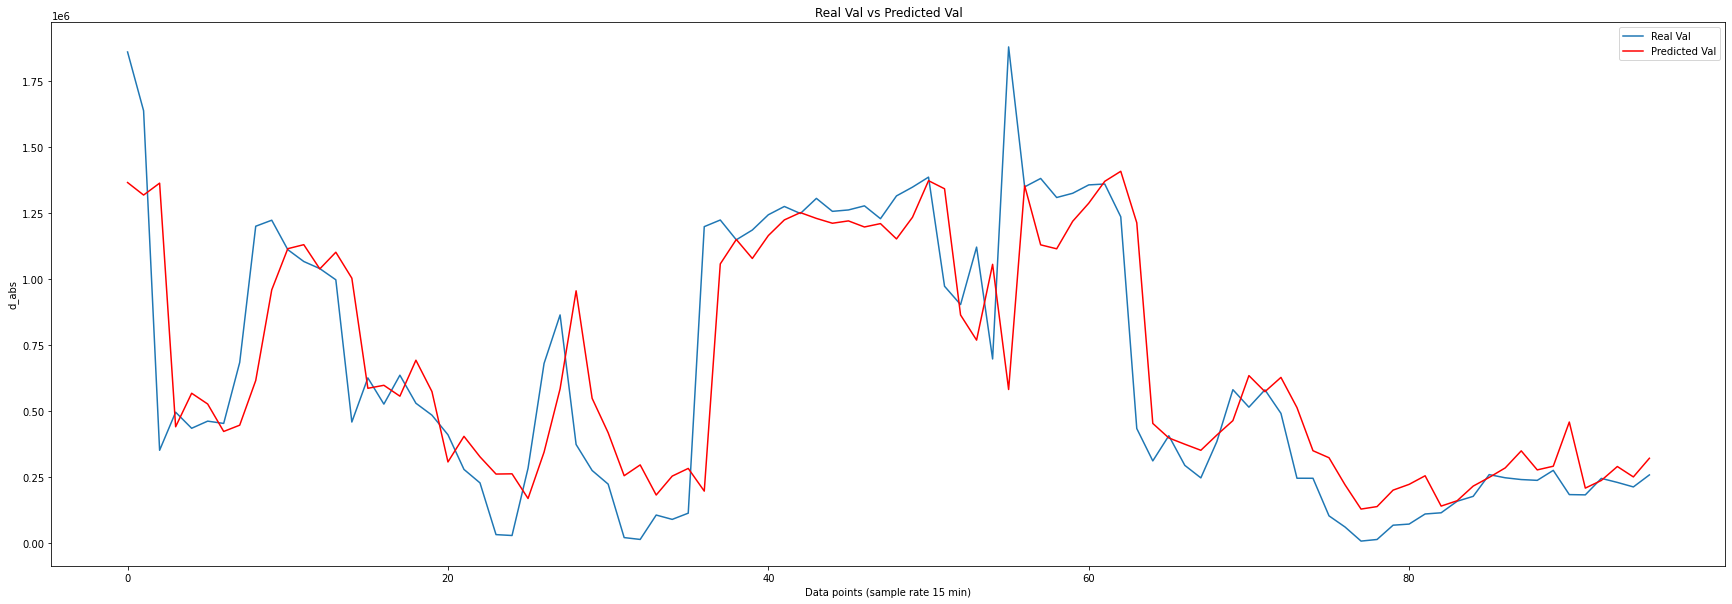

In [ ]:

  index = np.arange(0,96)
  fig, ax = plt.subplots(1,1,figsize=(30,10))
  plt.plot(index,y_test[0:96], label = 'Real Val')
  plt.plot(index,y_preds[0:96], label = 'Predicted Val',color='red')
  plt.title('Real Val vs Predicted Val')
  plt.xlabel('Data points (sample rate 15 min)')
  plt.ylabel('d_abs')
  plt.legend()
  plt.show()

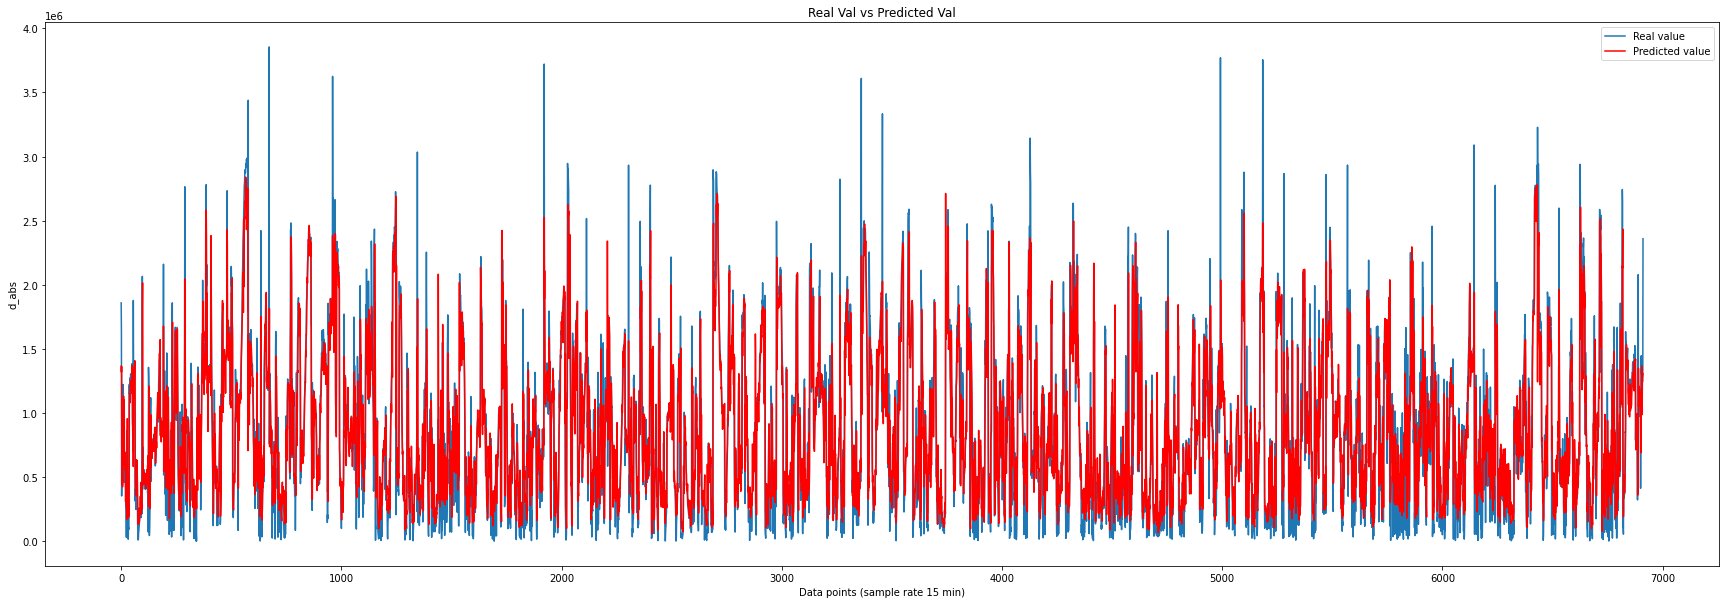

In [ ]:

  index = np.arange(len(y_test))
  fig, ax = plt.subplots(1,1,figsize=(30,10))
  plt.plot(index,y_test, label = 'Real value')
  plt.plot(index,y_preds, label = 'Predicted value',color='red')
  plt.title('Real Val vs Predicted Val')
  plt.xlabel('Data points (sample rate 15 min)')
  plt.ylabel('d_abs')
  plt.legend()
  plt.show()
  

In [ ]:
#dftestslice2=dftestslice2.reset_index()
#df_train=df_train.set_index('time')
#pred = model.fit(X_train,y_train).get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
#pred_ci = pred.conf_int()


for date, d in df_train.groupby(df_train['Dates']):
  fig, ax1 = plt.subplots(1,1,figsize=(16,7))
  ax1.set_title('Target value, actual value and absoulte error ',  fontsize=20)
  #ax1 = d['p_target'].plot(legend=True)
  ax1 = d['d_abs'].plot(legend=True,linestyle = '-',label='Real value')
  ax1 = d['prediction'].plot(color='red',legend=True,style='-',label='Predicted value')
  #ax1.set_xlabel(f",{d['Day']}")
  ax1.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax1.legend(loc='upper right')
  #ax1.set_xlabel(d['Day'])
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)




   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

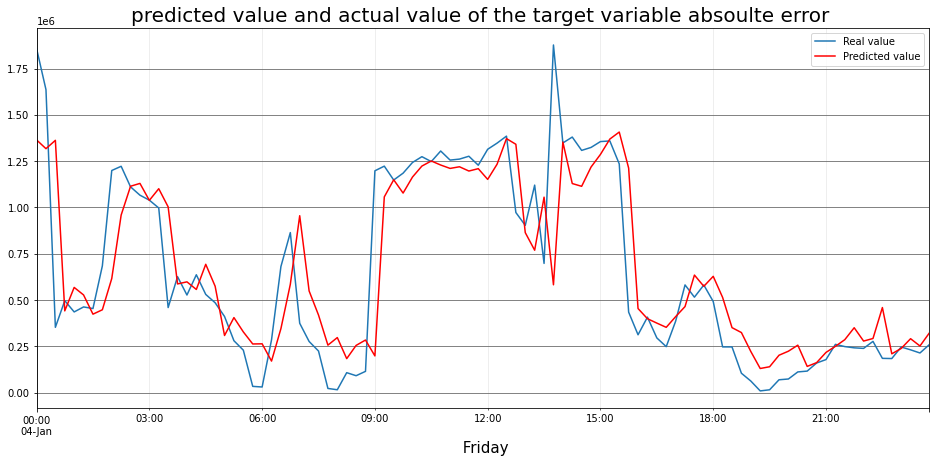

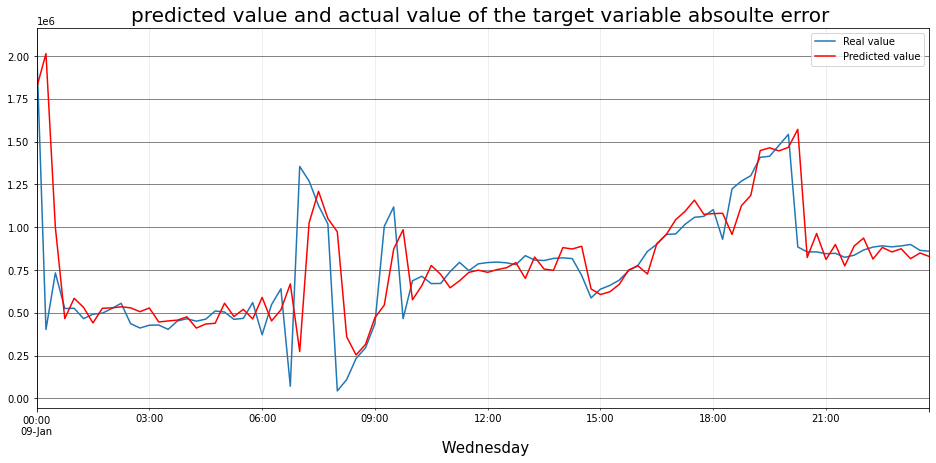

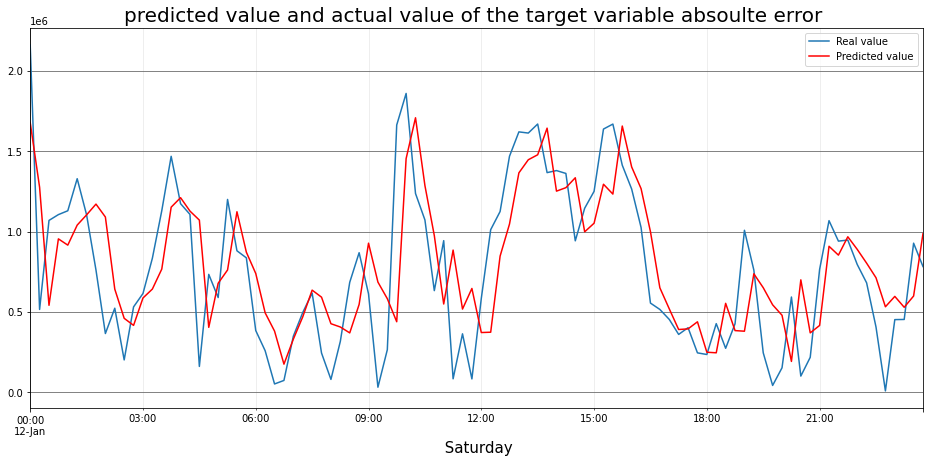

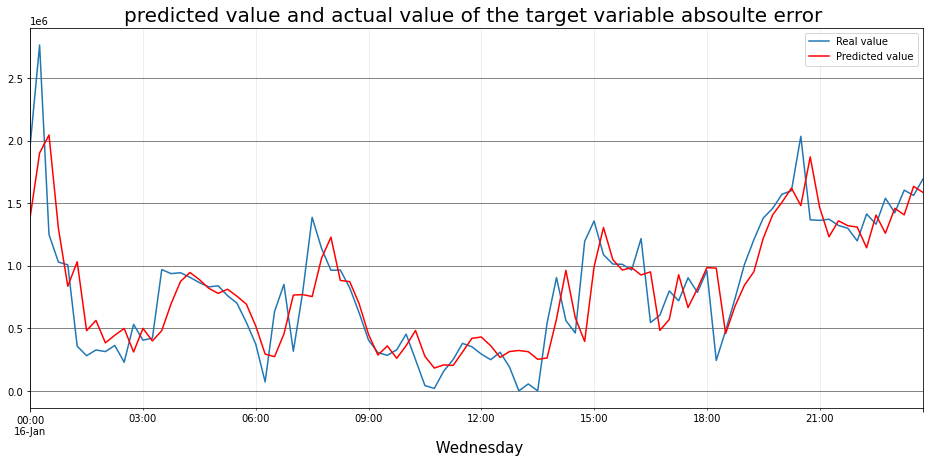

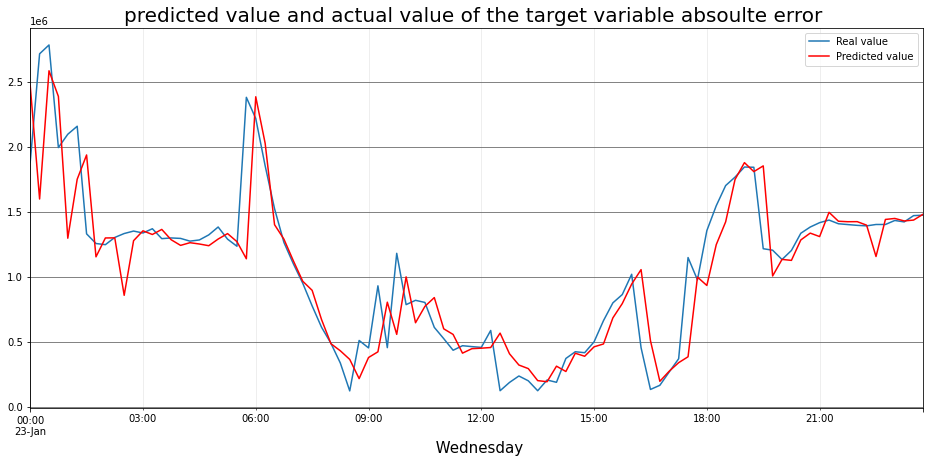

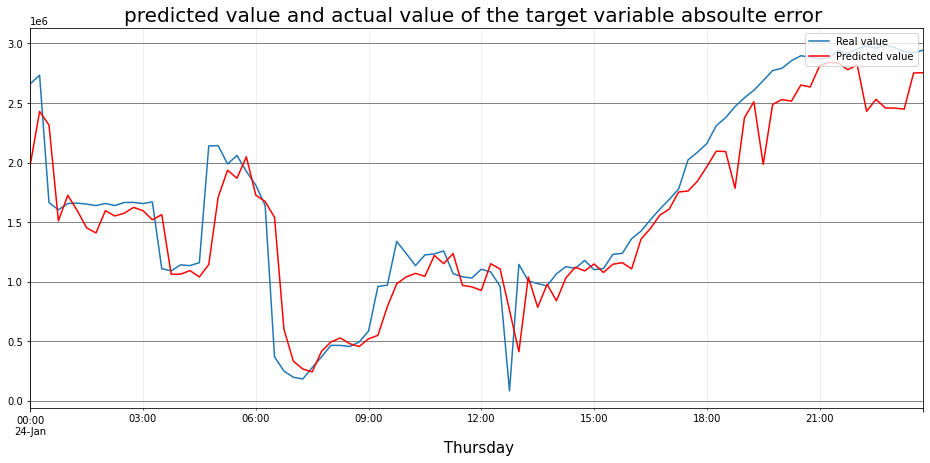

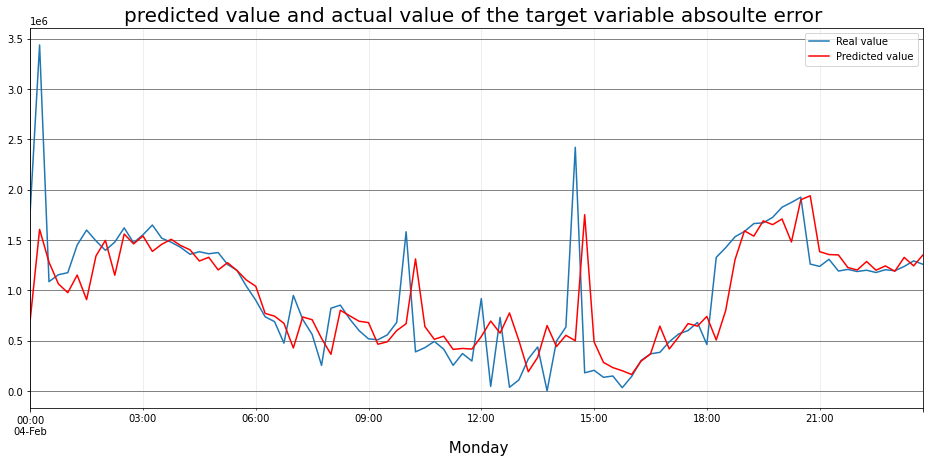

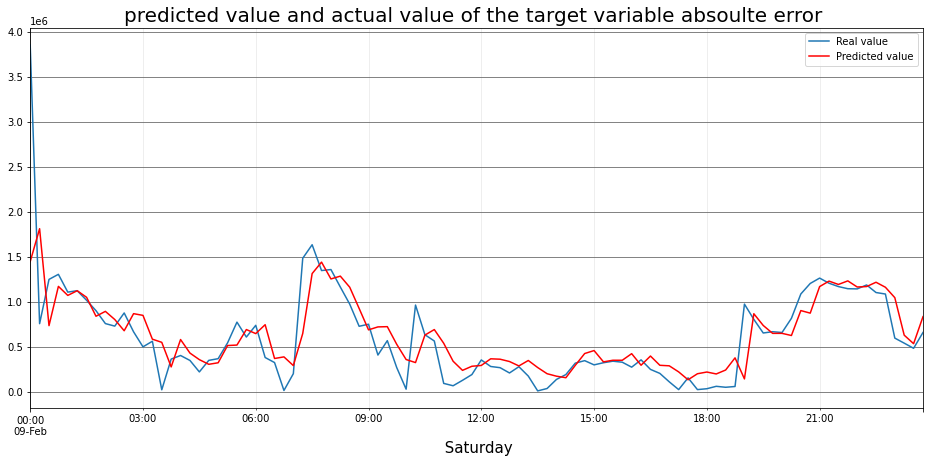

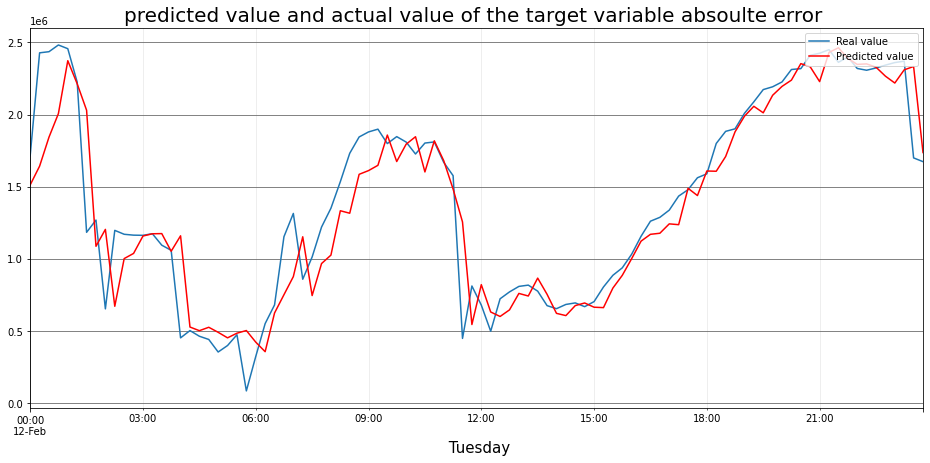

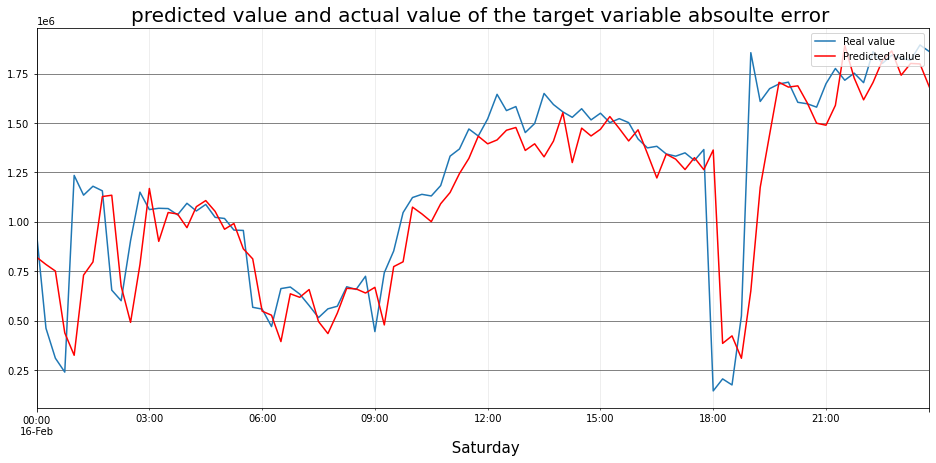

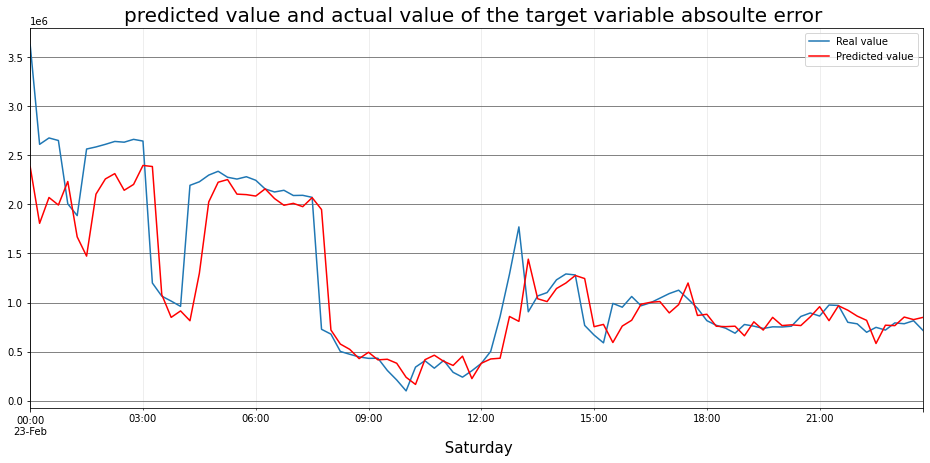

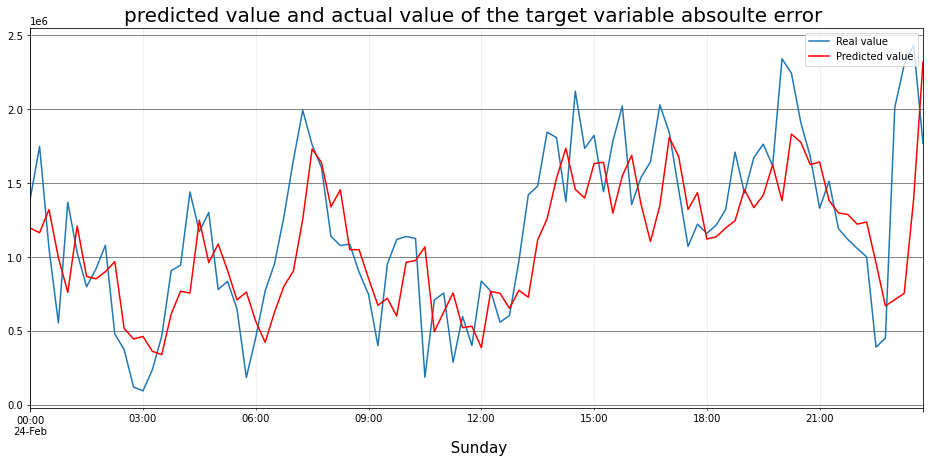

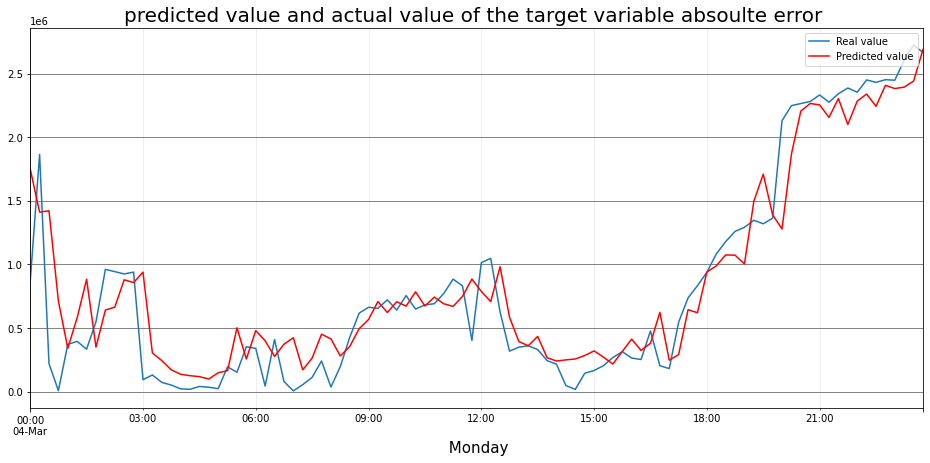

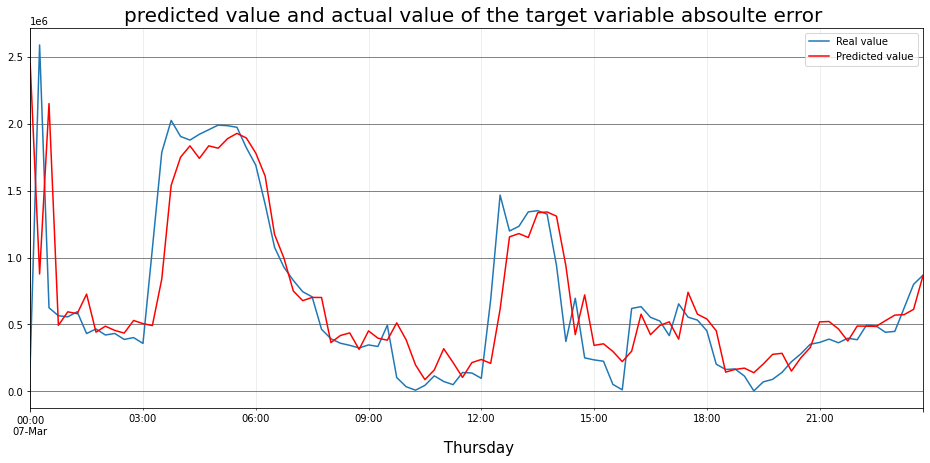

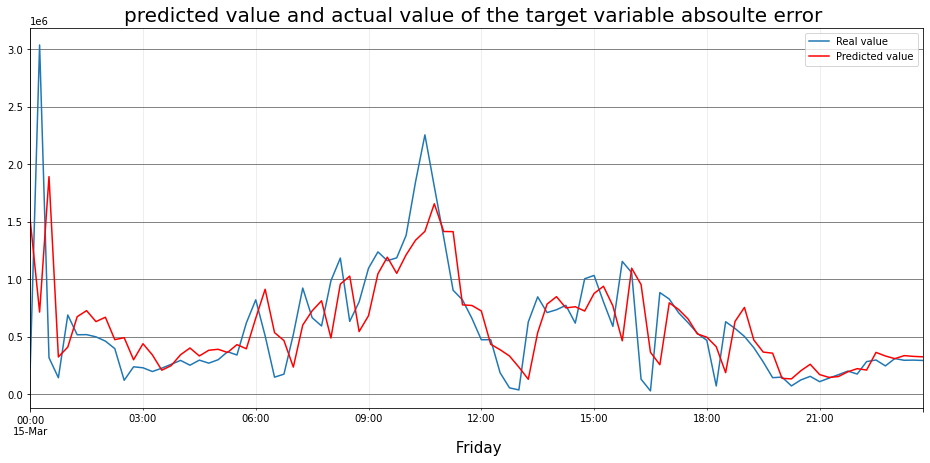

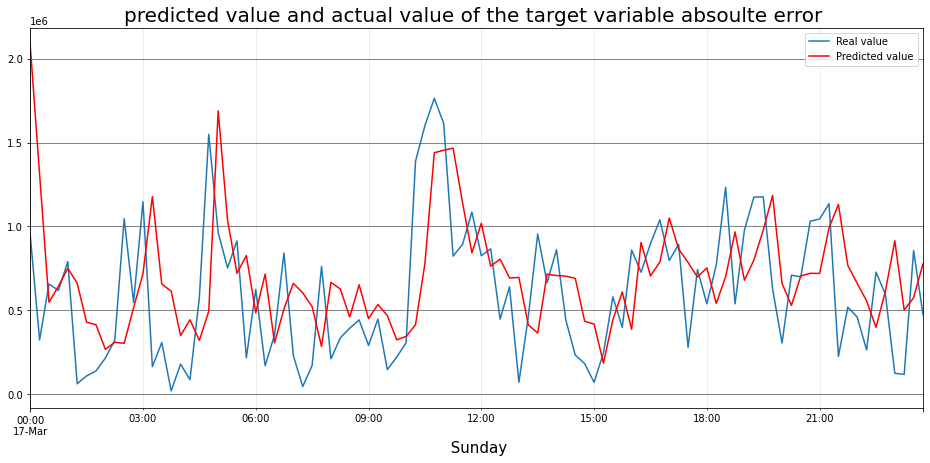

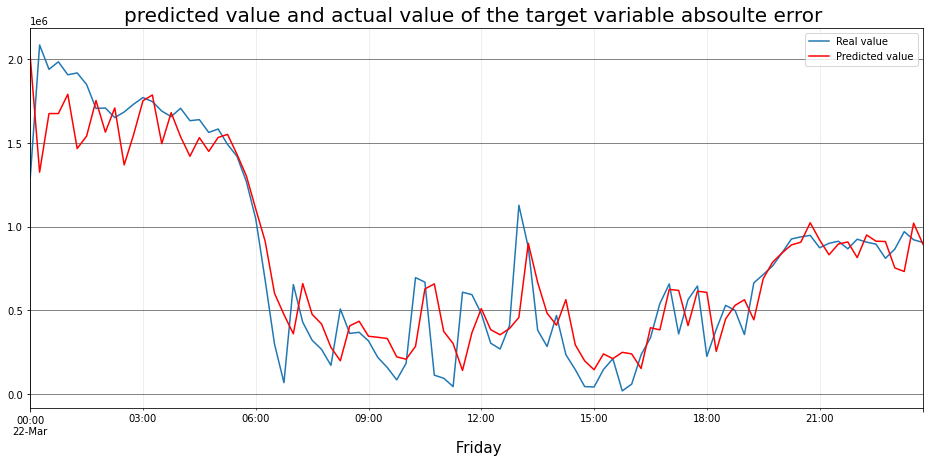

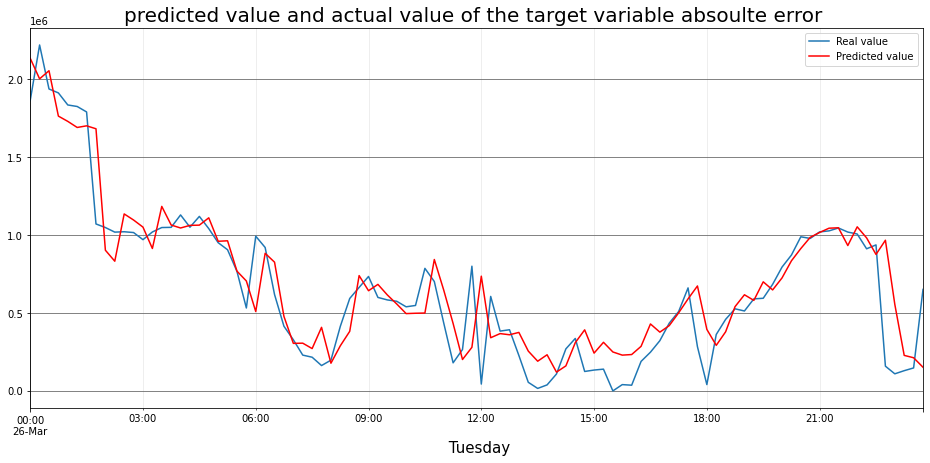

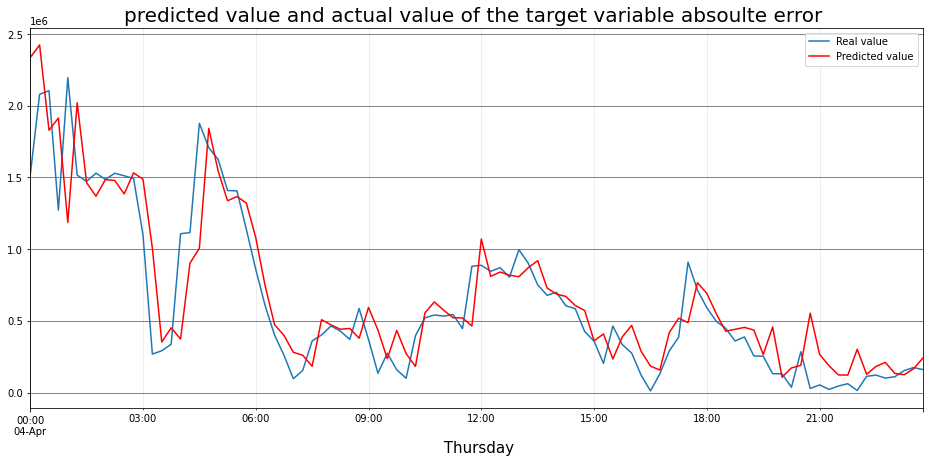

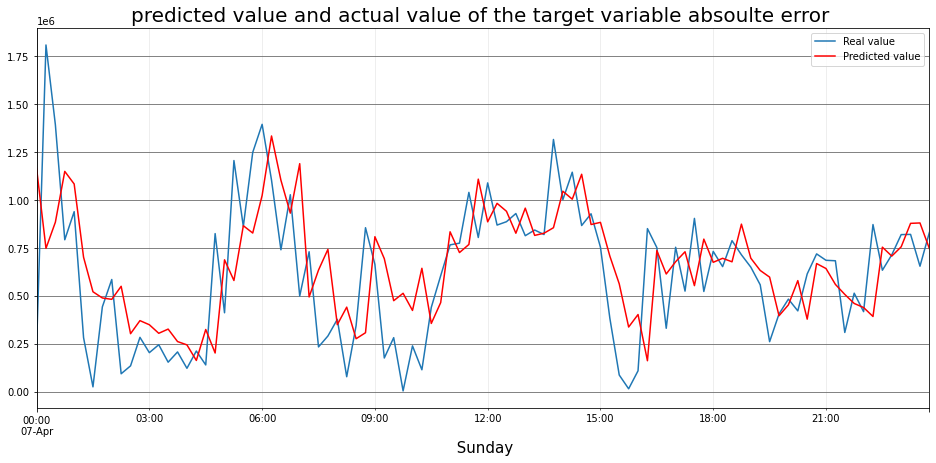

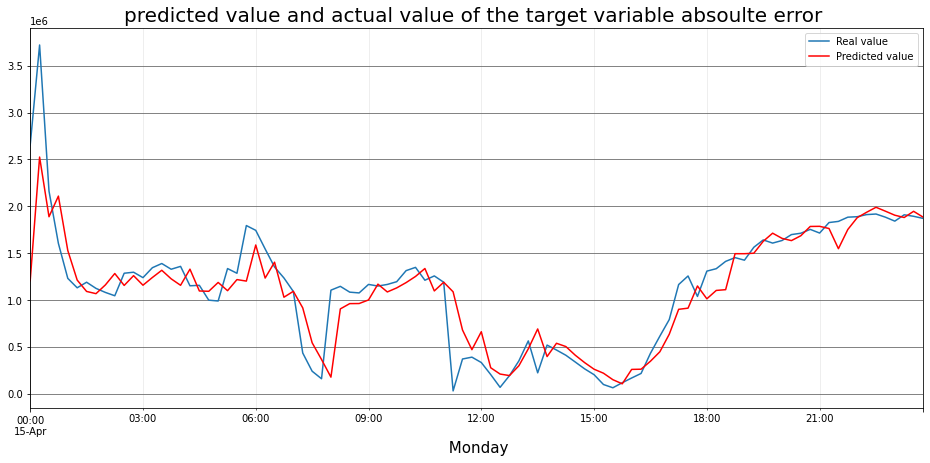

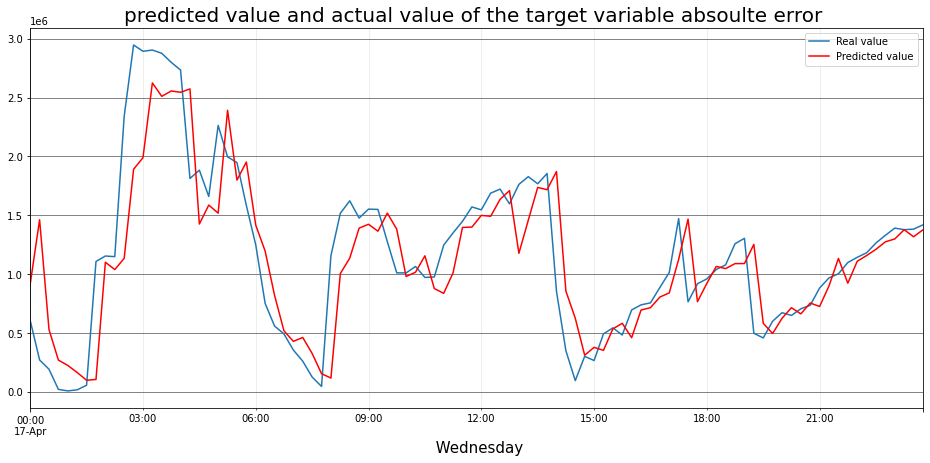

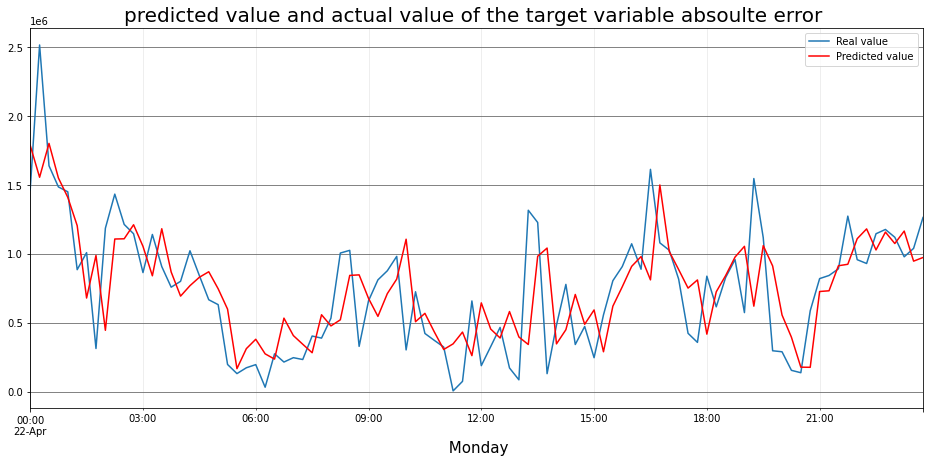

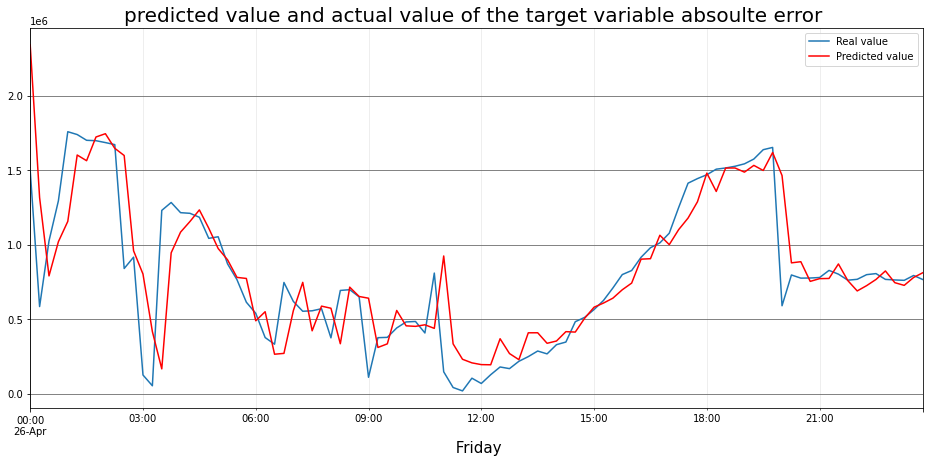

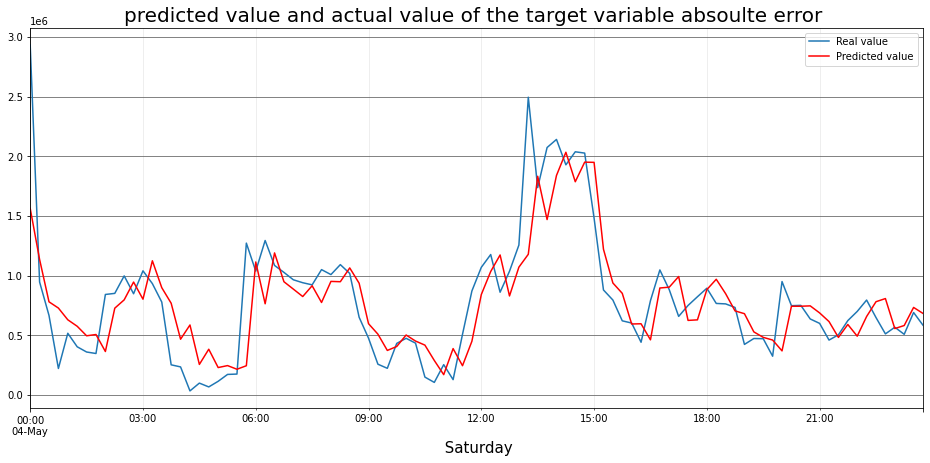

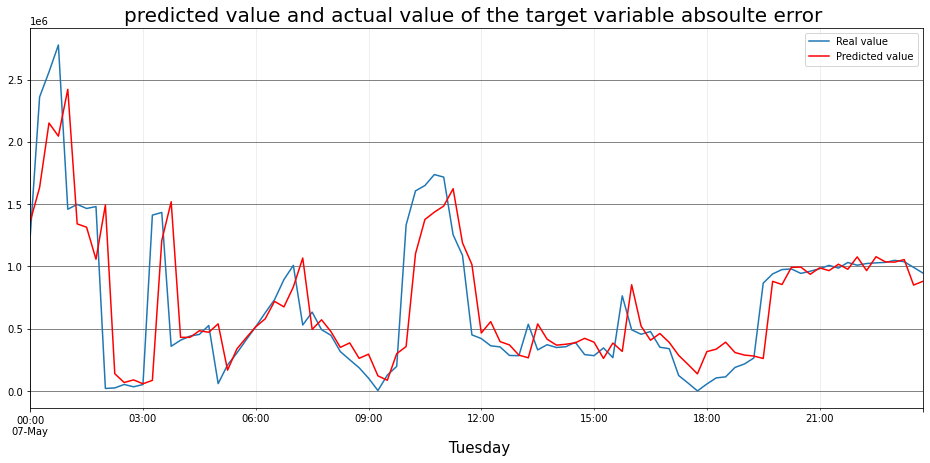

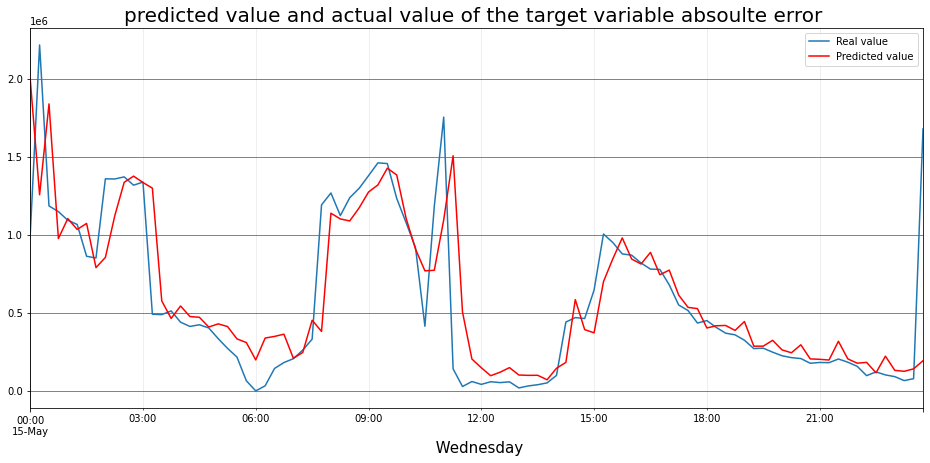

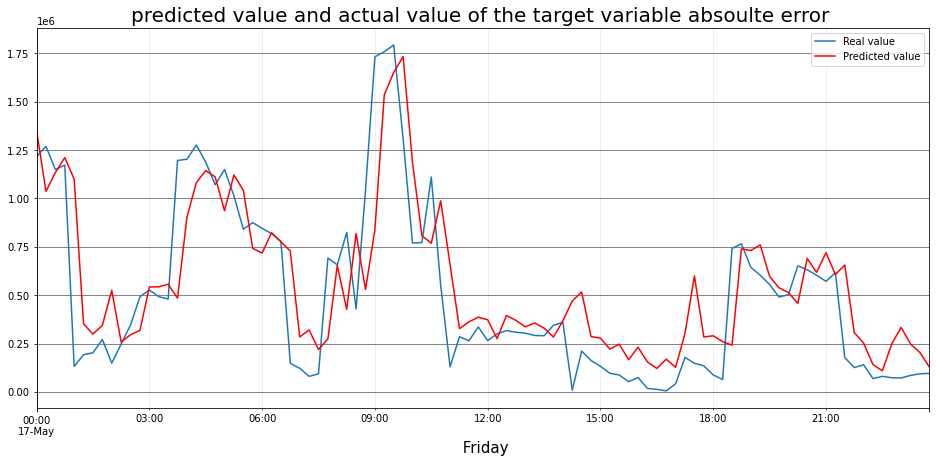

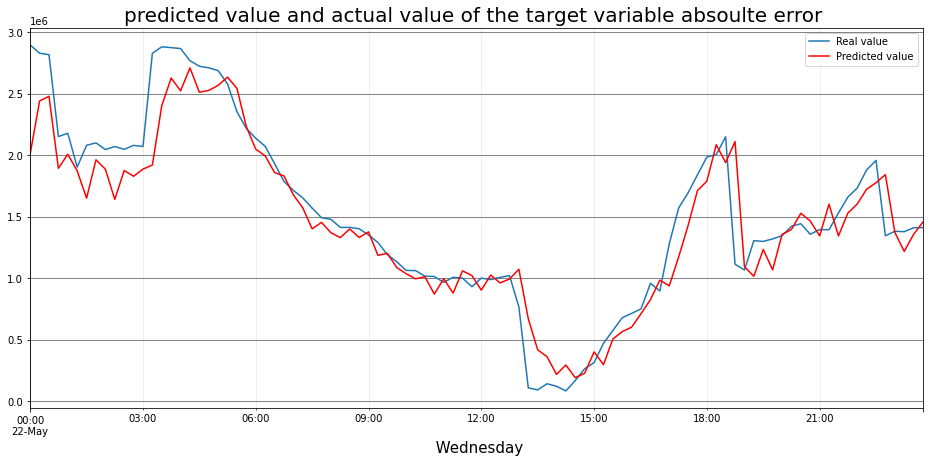

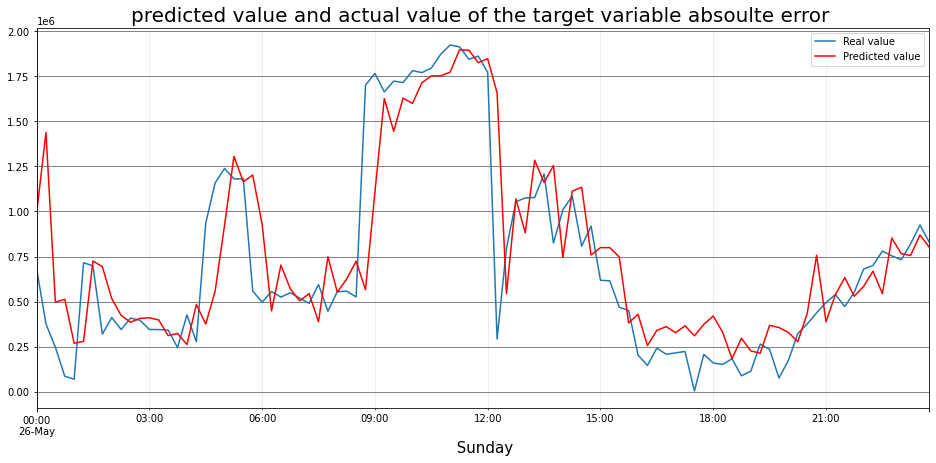

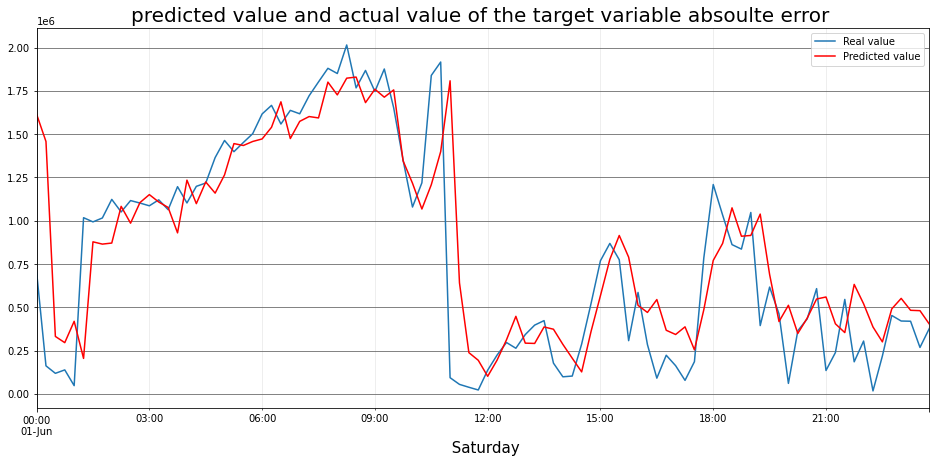

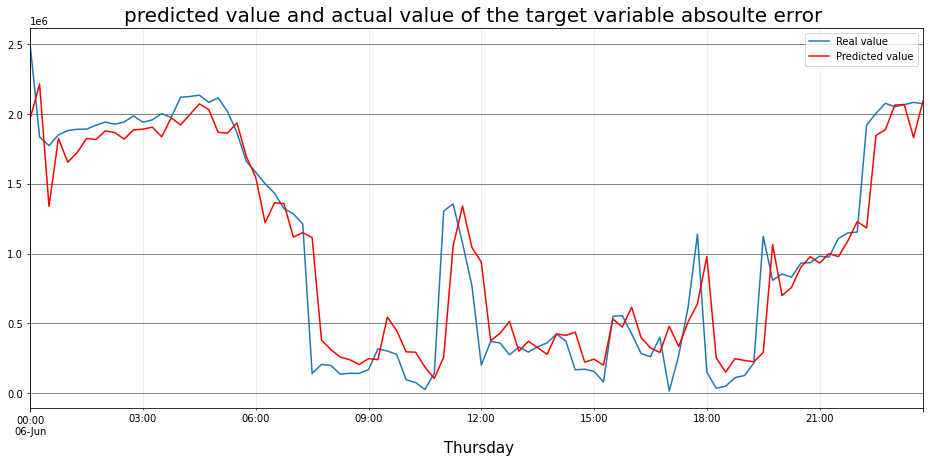

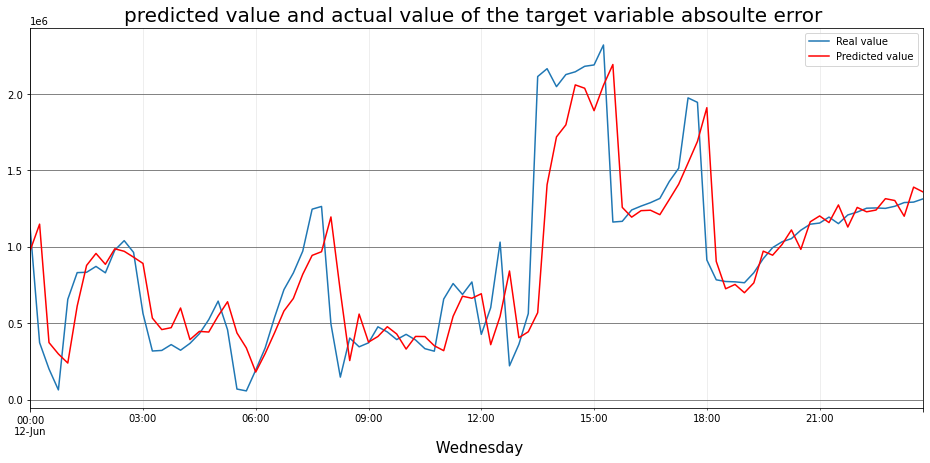

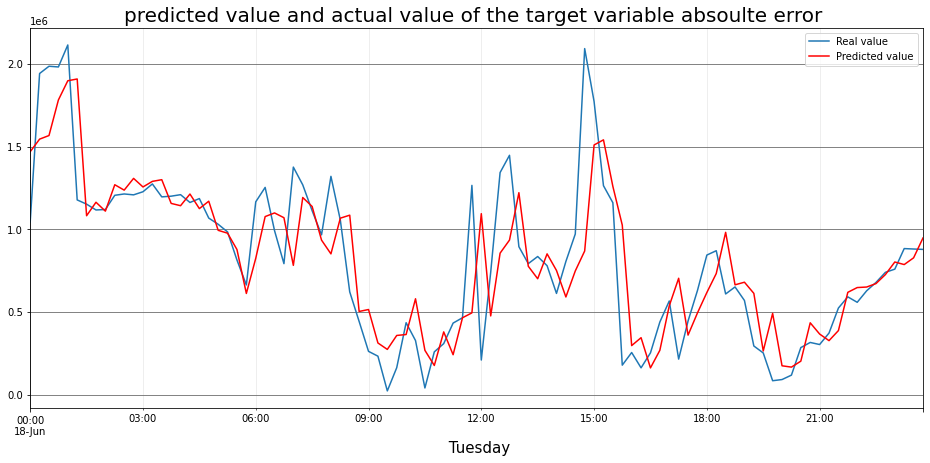

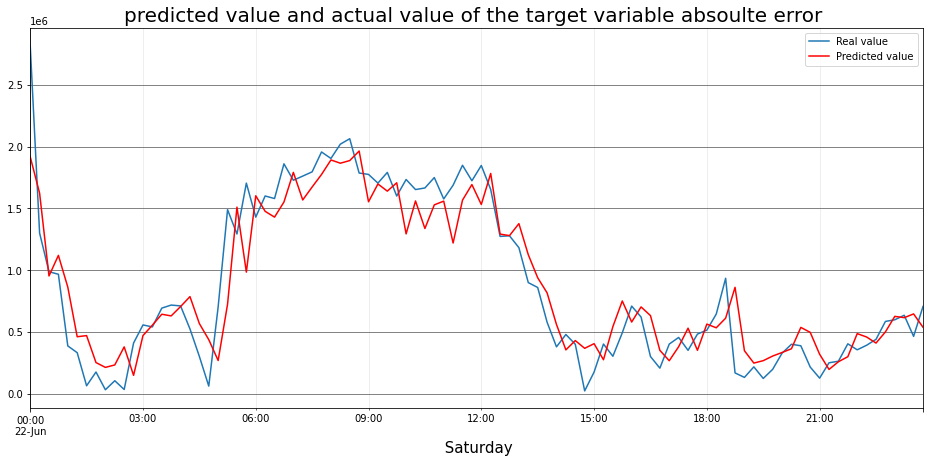

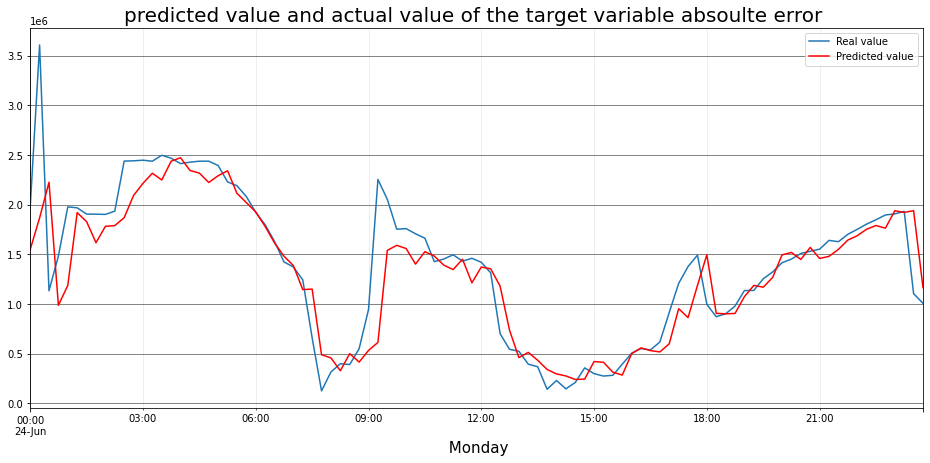

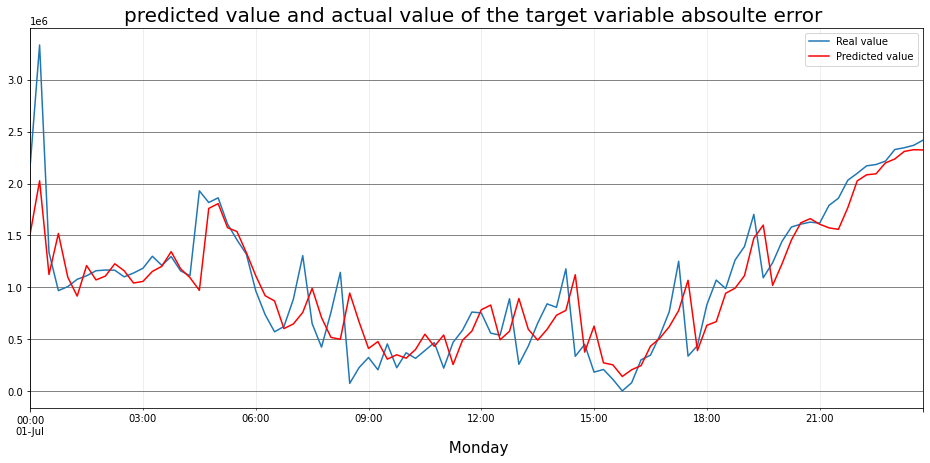

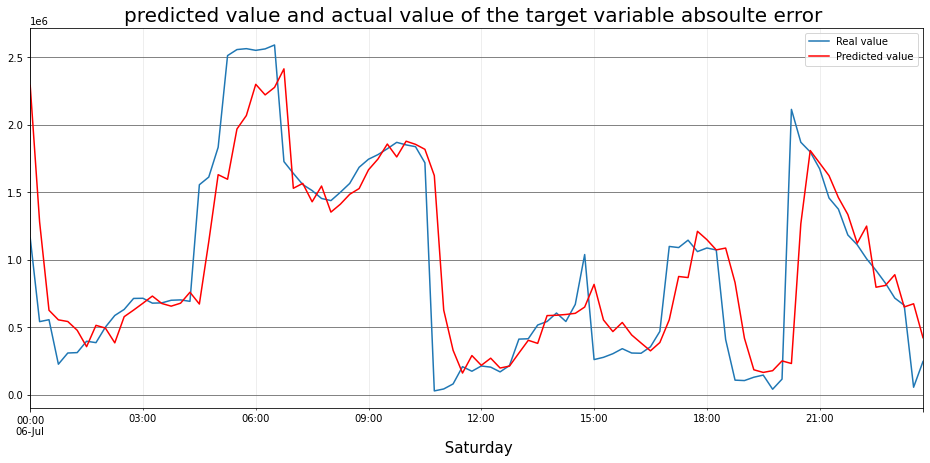

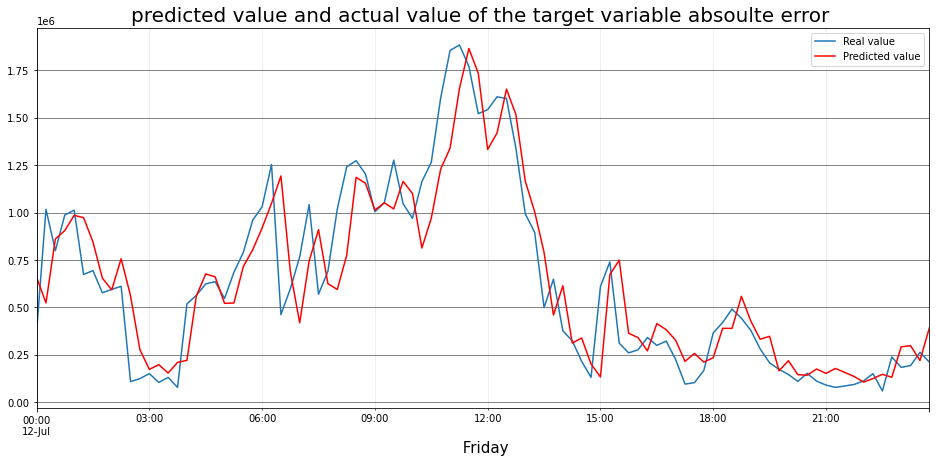

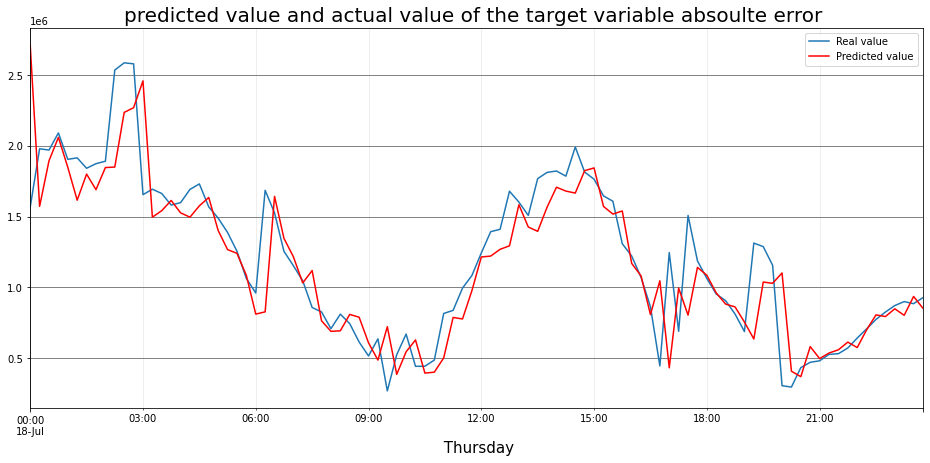

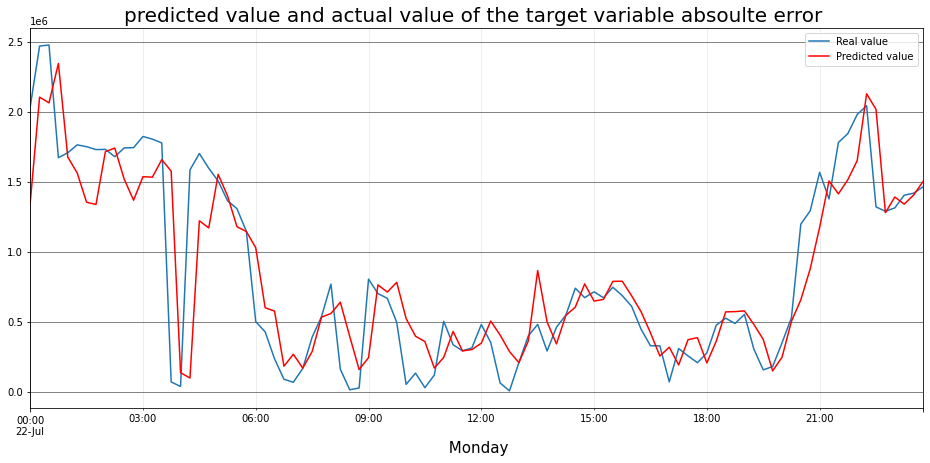

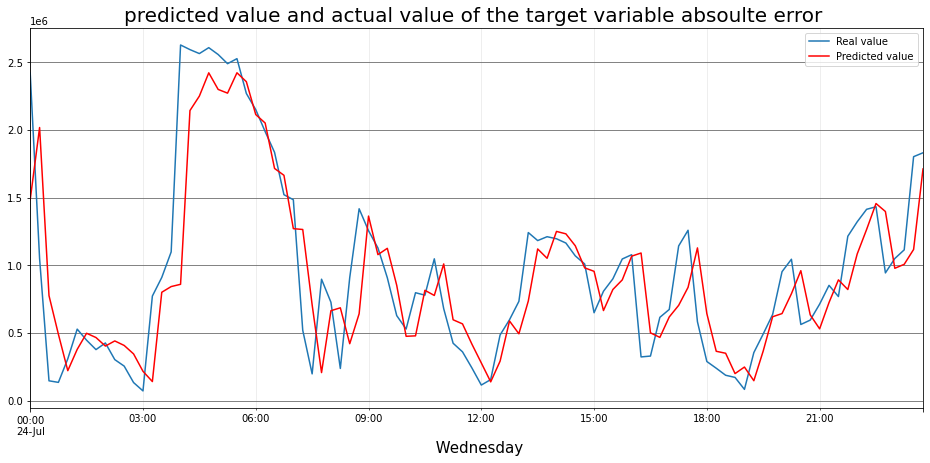

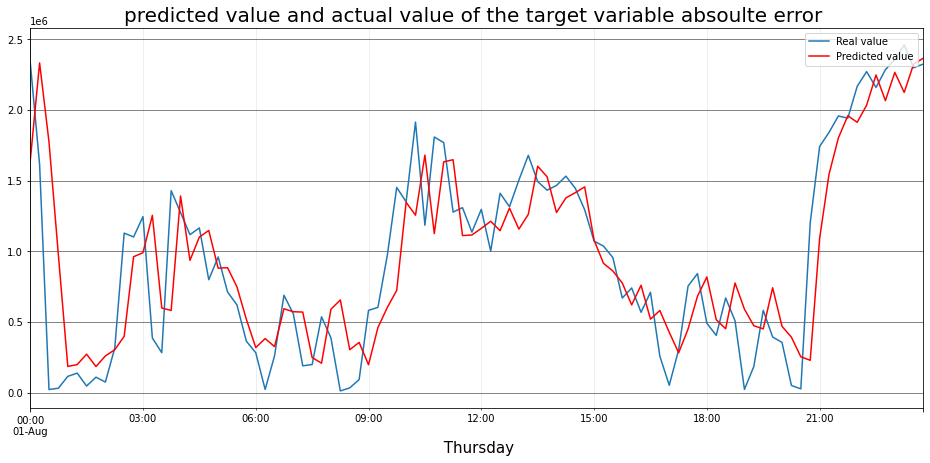

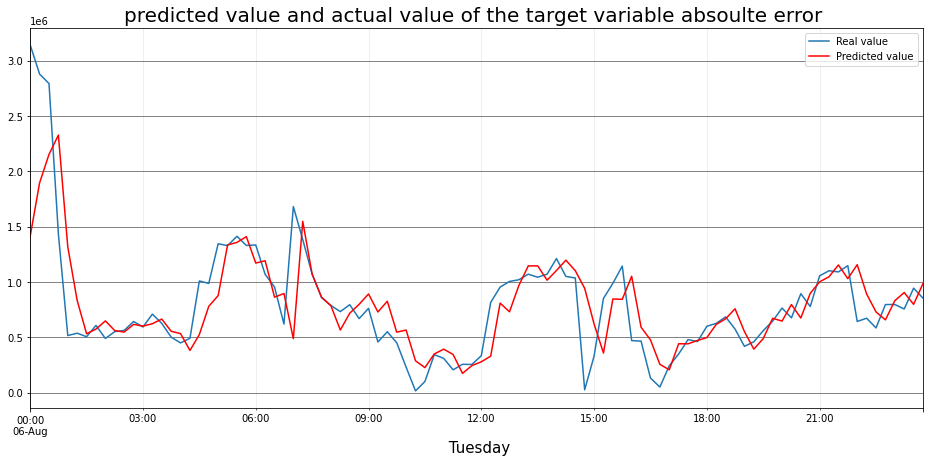

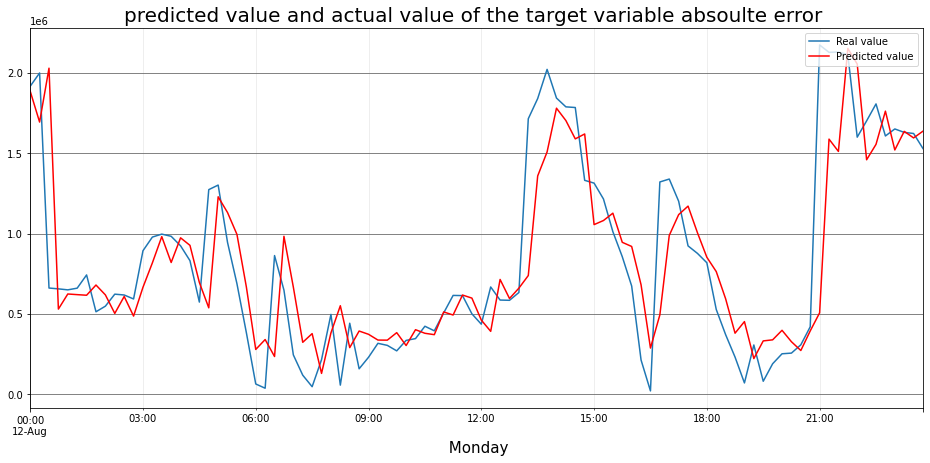

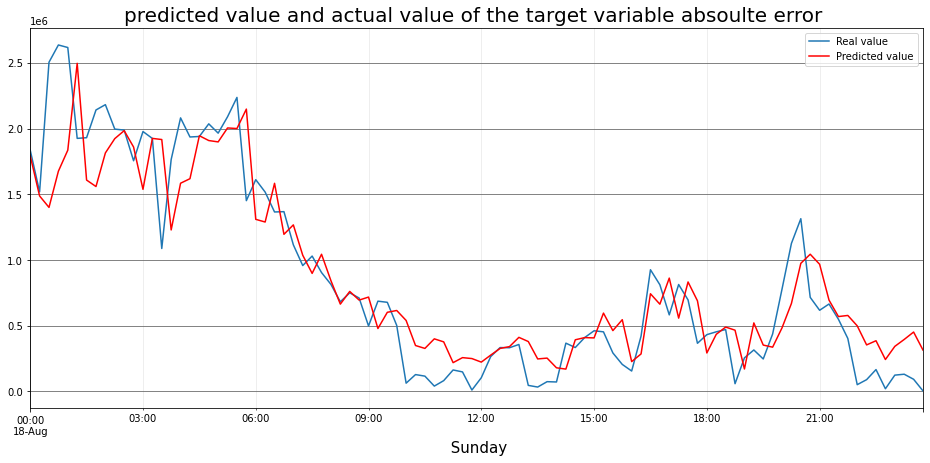

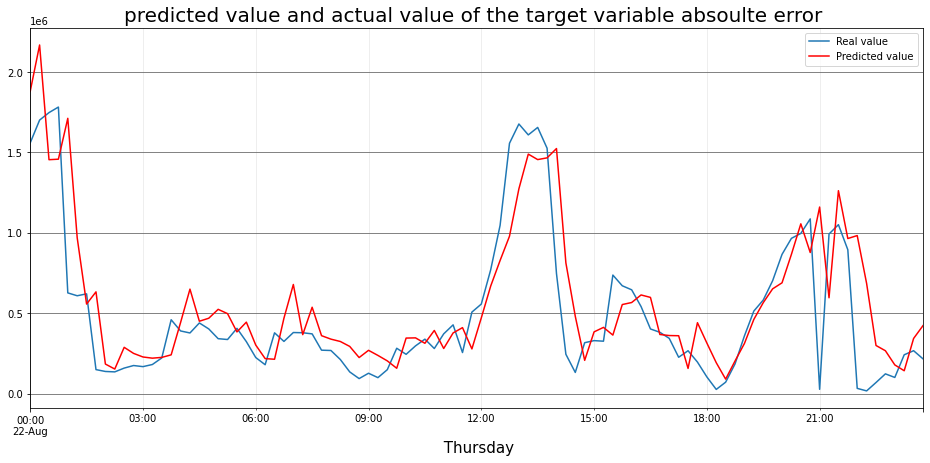

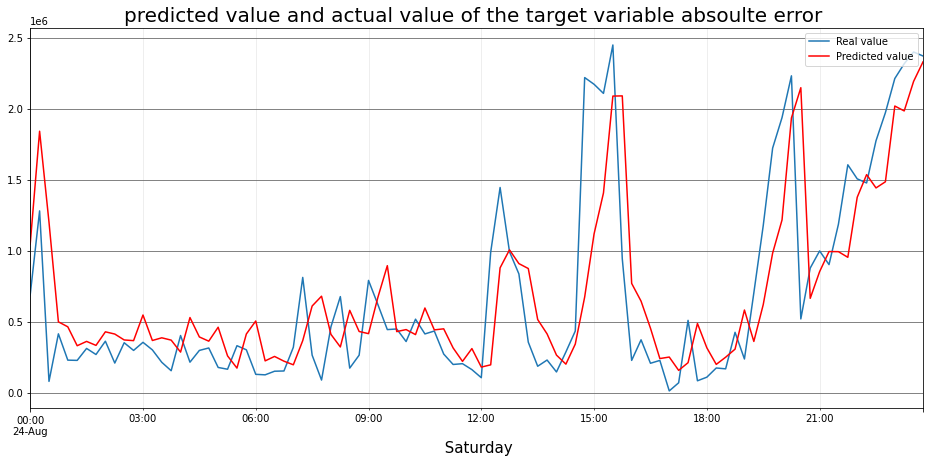

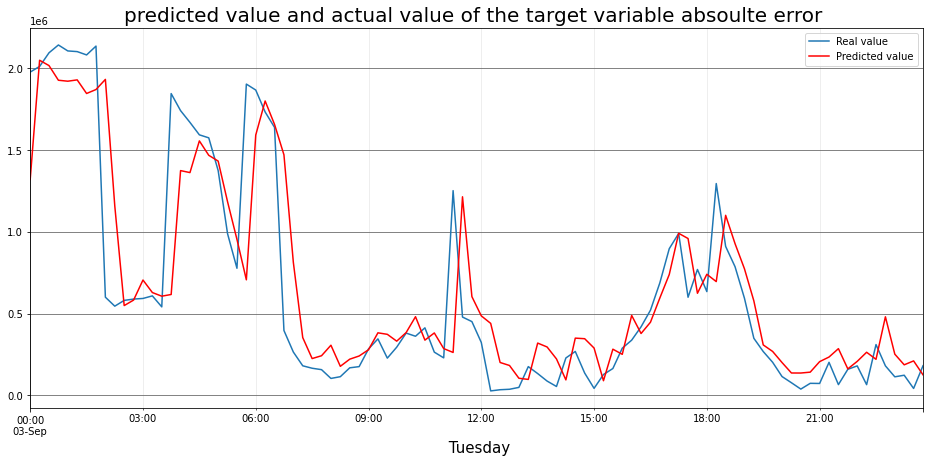

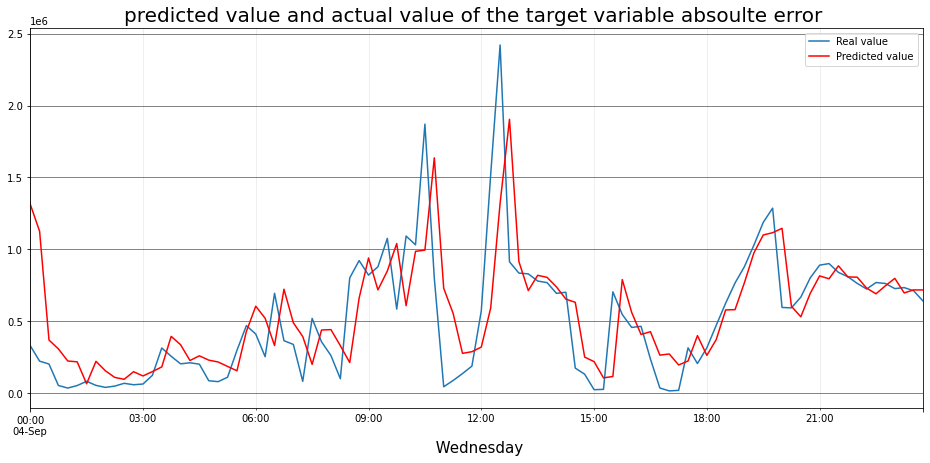

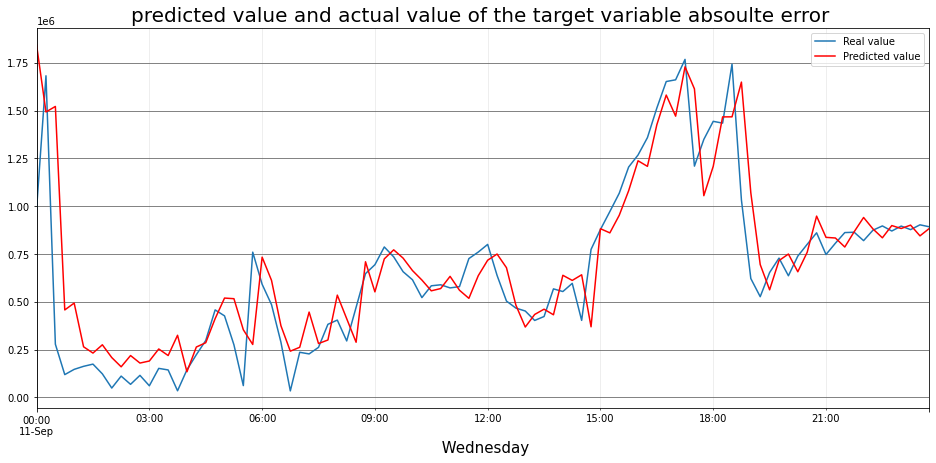

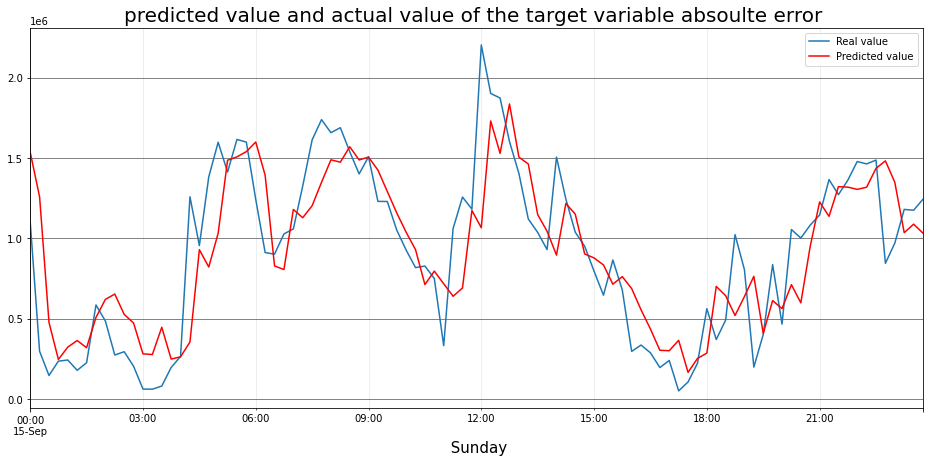

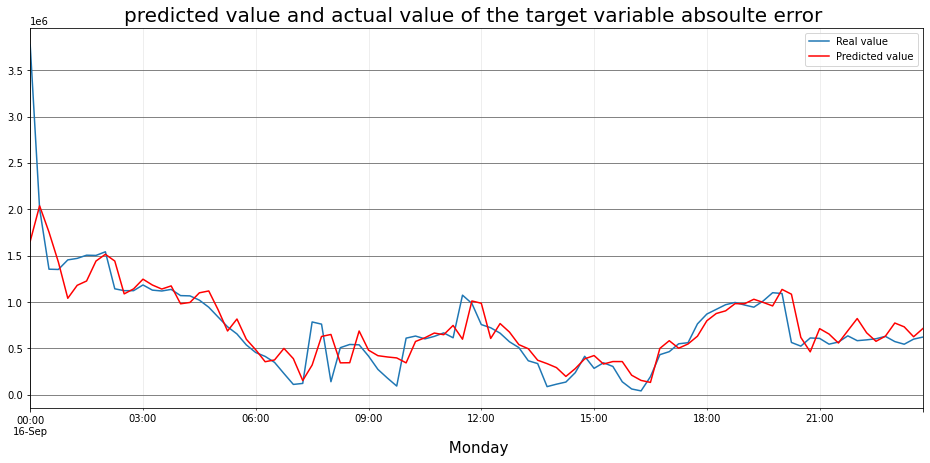

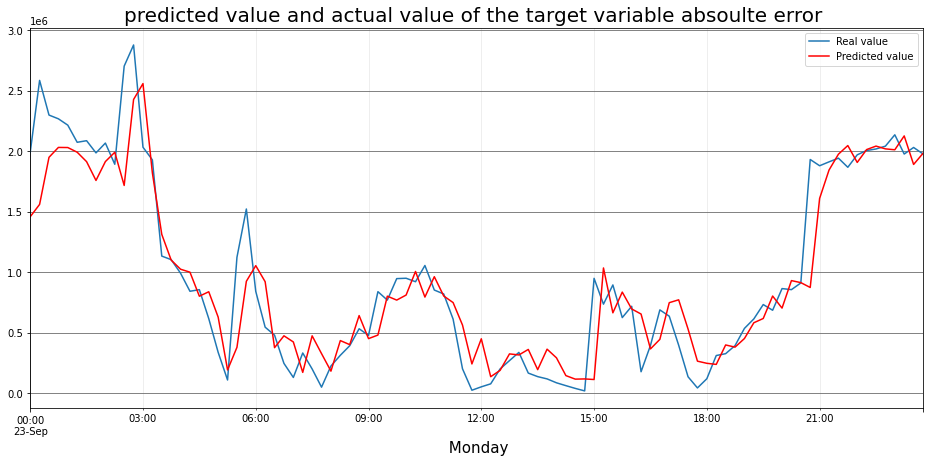

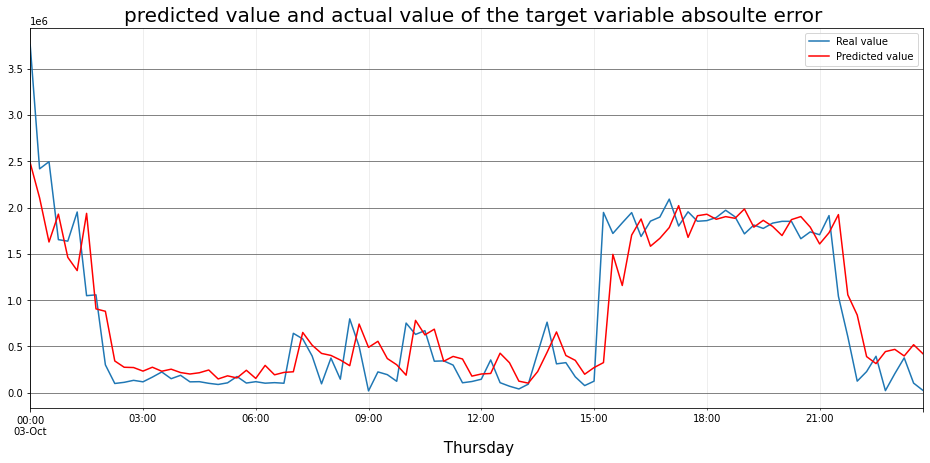

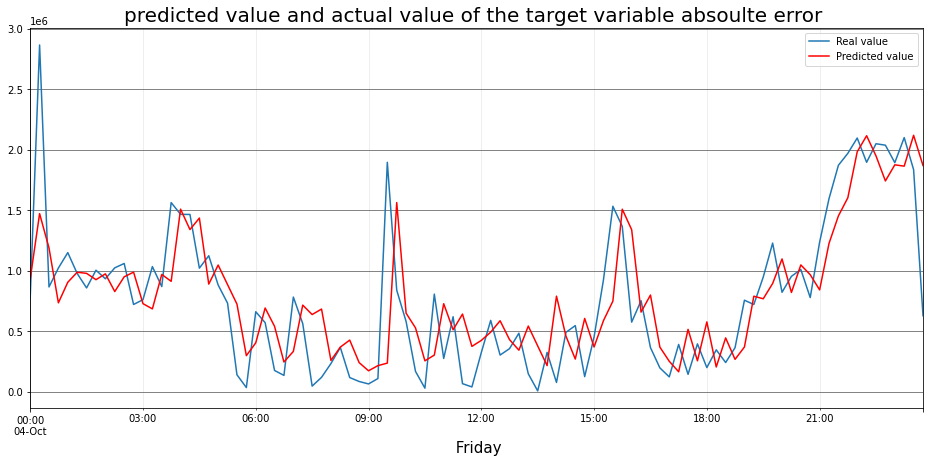

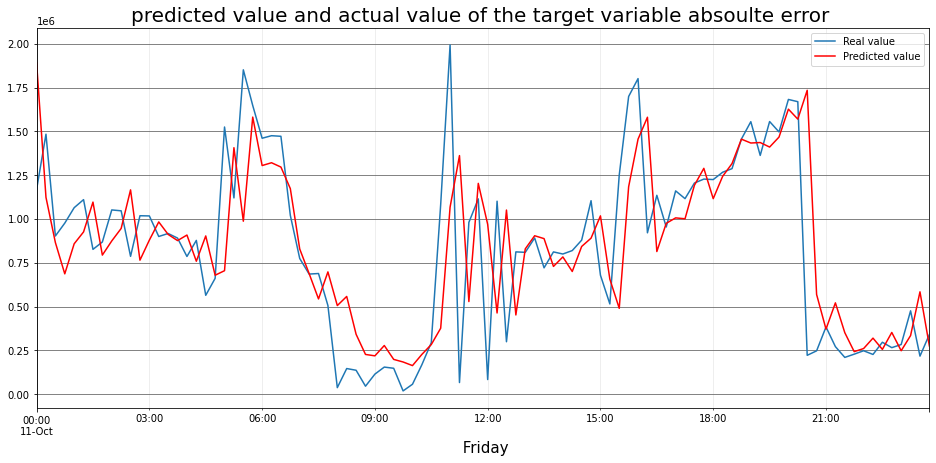

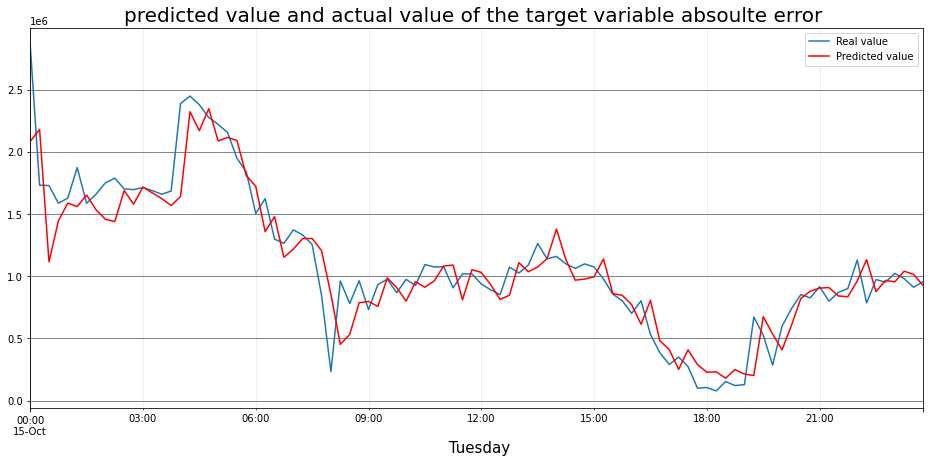

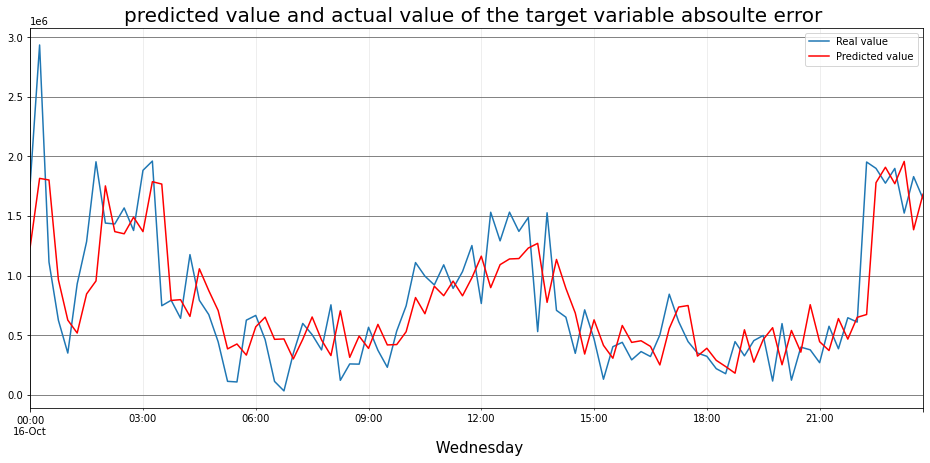

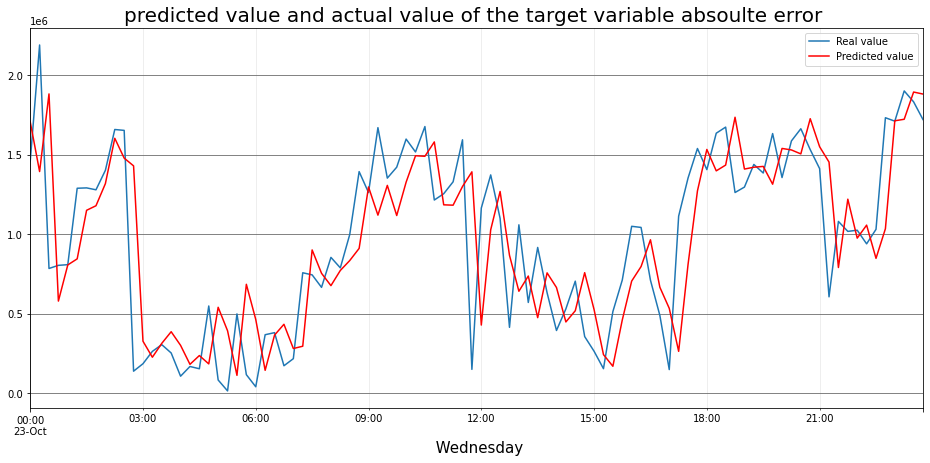

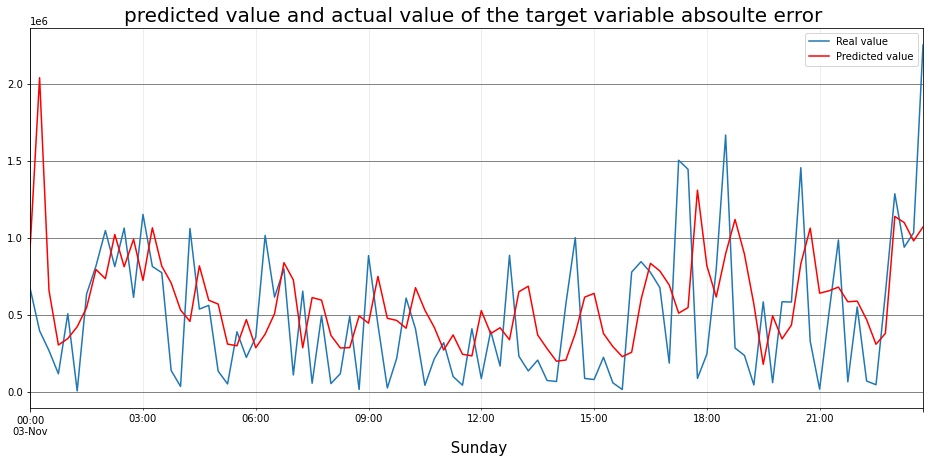

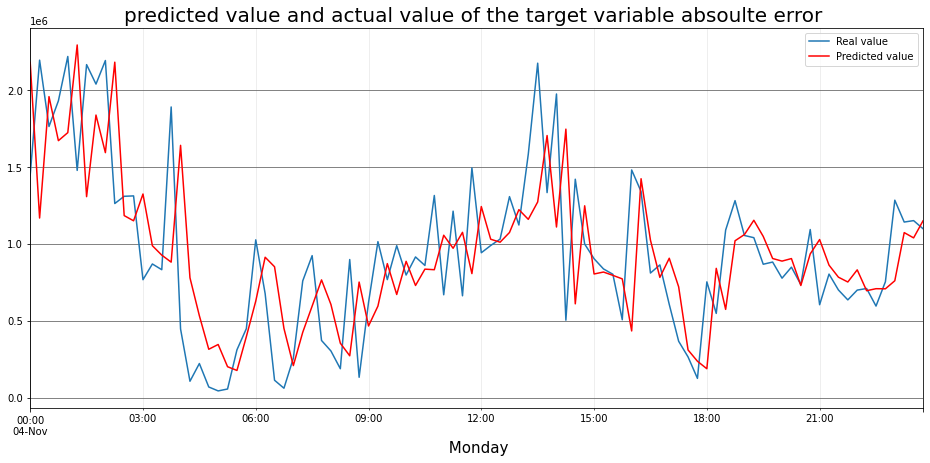

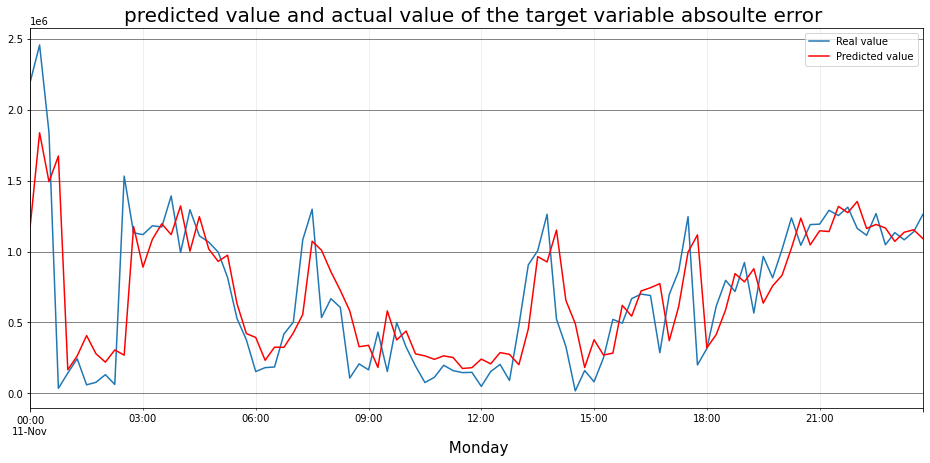

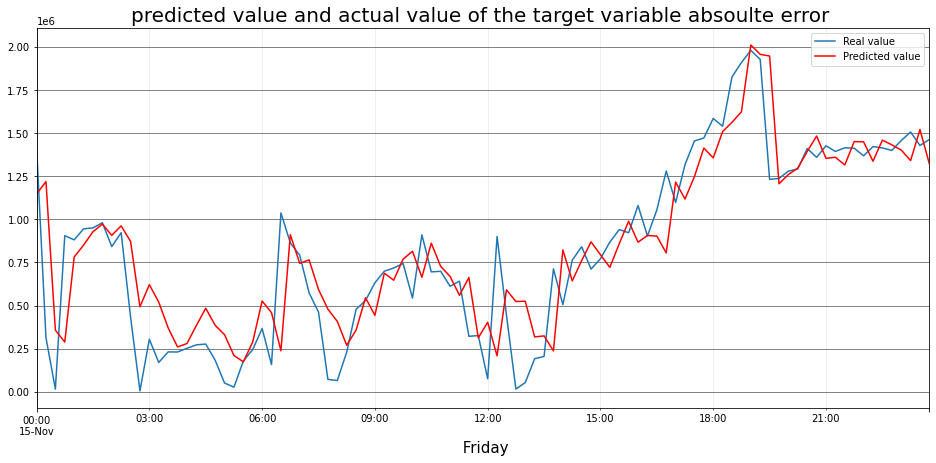

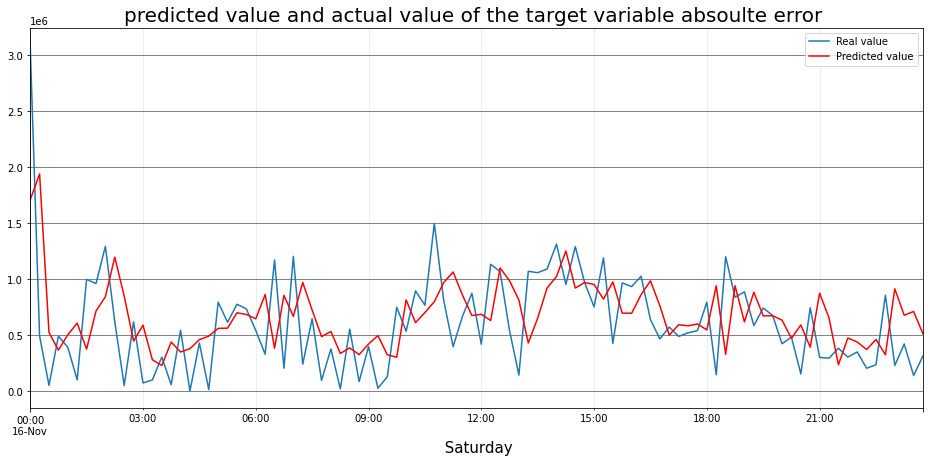

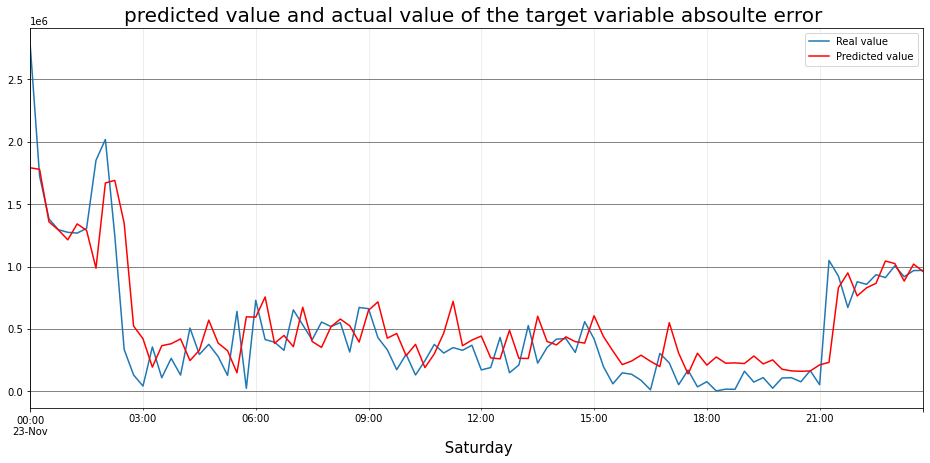

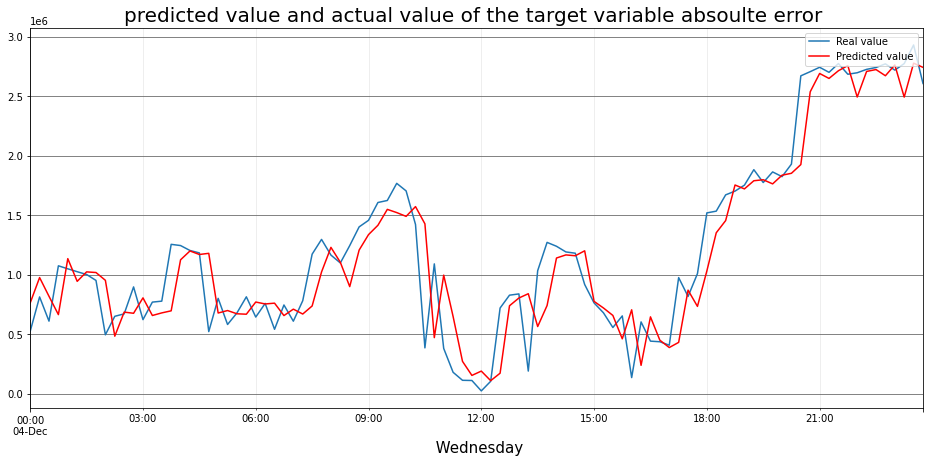

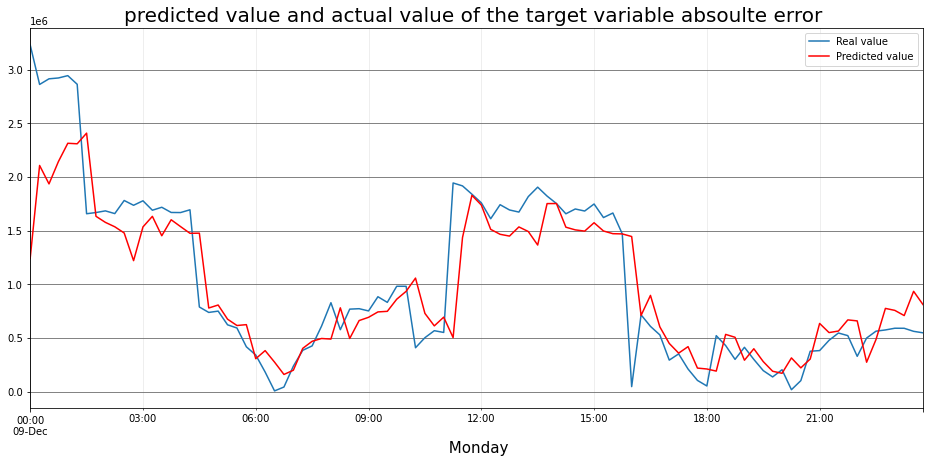

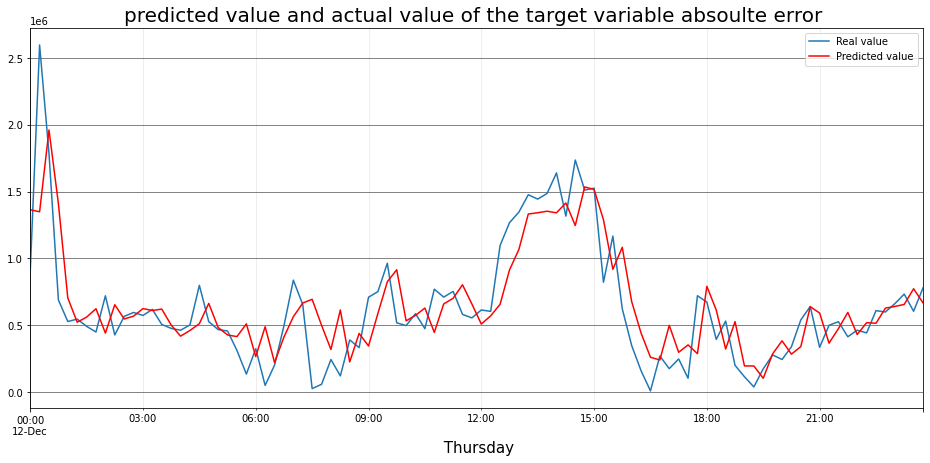

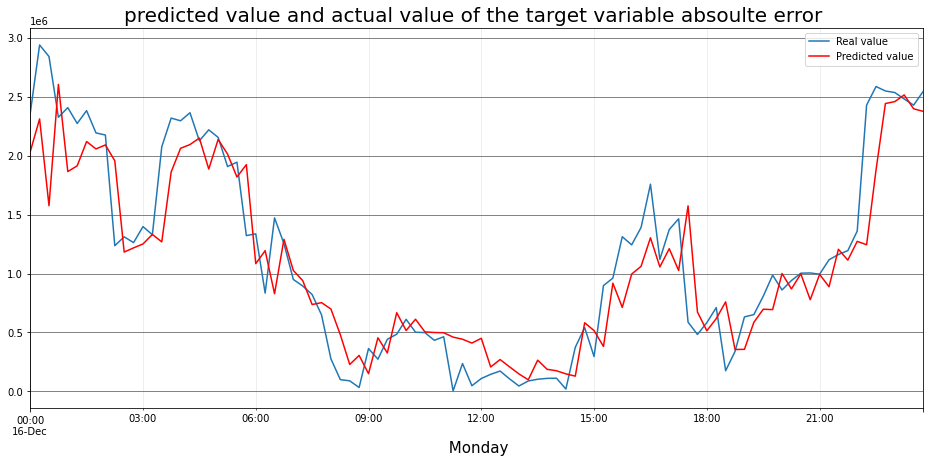

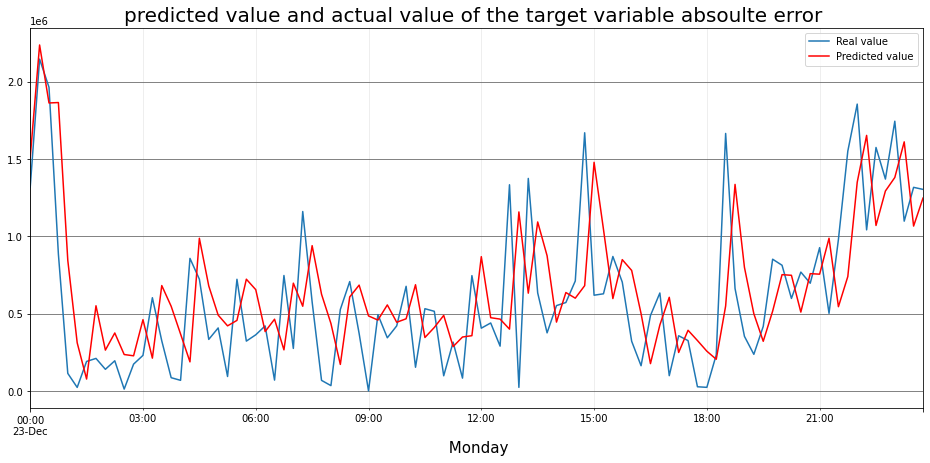

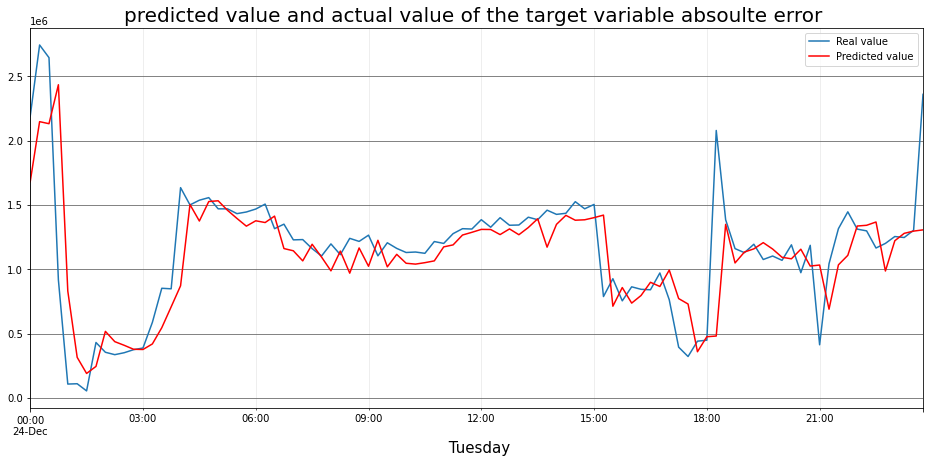

In [ ]:
#dftestslice2=dftestslice2.reset_index()
#df_train=df_train.set_index('time')
#pred = model.fit(X_train,y_train).get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
#pred_ci = pred.conf_int()
#df_for_testing=df_for_testing.set_index('time')

for date, d in df_for_testing.groupby(df_for_testing['Dates']):
  fig, ax1 = plt.subplots(1,1,figsize=(16,7))
  ax1.set_title('predicted value and actual value of the target variable absoulte error ',  fontsize=20)
  #ax1 = d['p_target'].plot(legend=True)
  ax1 = d['d_abs'].plot(legend=True,linestyle = '-',label='Real value')
  ax1 = d['prediction'].plot(color='red',legend=True,style='-',label='Predicted value')
  #ax1.set_xlabel(f",{d['Day']}")
  ax1.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax1.legend(loc='upper right')
  #ax1.set_xlabel(d['Day'])
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)




   

In [ ]:
df_train=df_train.reset_index()

In [ ]:
df_for_testing

Unnamed: 0          p_eh      p_target         d_abs           t-1  \
23520    352807.0  4.737116e+04 -1.929893e+06  1.977264e+06  1.166722e+06   
23521    352822.0  6.447461e+04 -1.947245e+06  2.011719e+06  1.977264e+06   
23522    352837.0  1.352419e+05 -1.959921e+06  2.095163e+06  2.011719e+06   
23523    352852.0  1.430226e+05 -2.000000e+06  2.143023e+06  2.095163e+06   
23524    352867.0  1.285781e+05 -1.978026e+06  2.106604e+06  2.143023e+06   
...           ...           ...           ...           ...           ...   
31387    470812.0  2.313339e+06  1.402205e+06  9.111339e+05  9.344246e+05   
31388    470827.0  2.313339e+06  1.307918e+06  1.005422e+06  9.111339e+05   
31389    470842.0  2.313339e+06  1.395111e+06  9.182283e+05  1.005422e+06   
31390    470857.0  2.313339e+06  1.346318e+06  9.670210e+05  9.182283e+05   
31391    470872.0  2.313339e+06  1.344064e+06  9.692754e+05  9.670210e+05   

                t-2           t-3       Dates Hour minute  ... DaysOfMonth  \
23520  1.172395e+06  1.169855e+06  2019-09-03    0      0  ...           3   
23521  1.166722e+06  1.172395e+06  2019-09-03    0     15  ...           3   
23522  1.977264e+06  1.166722e+06  2019-09-03    0     30  ...           3   
23523  2.011719e+06  1.977264e+06  2019-09-03    0     45  ...           3   
23524  2.095163e+06  2.011719e+06  2019-09-03    1      0  ...           3   
...             ...           ...         ...  ...    ...  ...         ...   
31387  8.571362e+05  8.778652e+05  2019-11-23   22     45  ...          23   
31388  9.344246e+05  8.571362e+05  2019-11-23   23      0  ...          23   
31389  9.111339e+05  9.344246e+05  2019-11-23   23     15  ...          23   
31390  1.005422e+06  9.111339e+05  2019-11-23   23     30  ...          23   
31391  9.182283e+05  1.005422e+06  2019-11-23   23     45  ...          23   

      Seasons Weekend WeekOfYear Holiday DayAheadWeekend DayAfterWeekend  \
23520       0       0         36       0               0               0   
23521       0       0         36       0               0               0   
23522       0       0         36       0               0               0   
23523       0       0         36       0               0               0   
23524       0       0         36       0               0               0   
...       ...     ...        ...     ...             ...             ...   
31387       0       1         47       0               0               0   
31388       0       1         47       0               0               0   
31389       0       1         47       0               0               0   
31390       0       1         47       0               0               0   
31391       0       1         47       0               0               0   

      WeekOfMonth    prediction                time  
23520           2  2.448140e+06 2019-09-03 00:00:00  
23521           2  1.869970e+06 2019-09-03 00:15:00  
23522           2  1.504624e+06 2019-09-03 00:30:00  
23523           2  2.116119e+06 2019-09-03 00:45:00  
23524           2  2.028527e+06 2019-09-03 01:00:00  
...           ...           ...                 ...  
31387           4  9.985769e+05 2019-11-23 22:45:00  
31388           4  1.004721e+06 2019-11-23 23:00:00  
31389           4  9.625797e+05 2019-11-23 23:15:00  
31390           4  1.049858e+06 2019-11-23 23:30:00  
31391           4  9.476748e+05 2019-11-23 23:45:00  

[1728 rows x 27 columns]

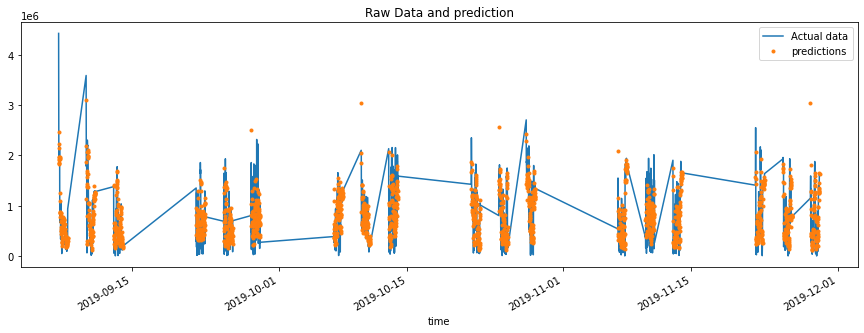

In [ ]:
#predition ploted heir im Bezug auf unsere orginale Dataset
#df_train=df_train.reset_index()
#df_train=df_train.set_index('Dates')
ax=df_for_testing[['d_abs']].plot(figsize=(15,5))
df_for_testing[['prediction']].plot(ax=ax,style='.')
ax.set_title('Raw Data and prediction')
plt.legend(['Actual data','predictions'])
plt.show()